In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os,gc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,roc_curve,auc,confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
import time
plt.style.use('seaborn-whitegrid')
import warnings
warnings.simplefilter("ignore")
colors = [x['color'] for x in plt.rcParams['axes.prop_cycle']]

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/iee-fraud detection')

In [ ]:
df_train = pd.read_csv('data/train_combined.csv')
df_test = pd.read_csv('data/test_combined.csv')
print(df_train.shape)
print(df_test.shape)

(590540, 434)
(506691, 433)


In [ ]:
def top_missing_cols(df,n=10,thresh=80):
    """
    returns missing columns in dataframe with missing values percent > thresh
    if n=None. It will gave whole dataframe with missing values percent > thresh
    """
    
    dff = (df.isnull().sum()/df.shape[0])*100
    dff = dff.reset_index()
    dff.columns = ['col','missing_percent']
    dff = dff.sort_values(by=['missing_percent'],ascending=False).reset_index(drop=True)
    print(f'There are {df.isnull().any().sum()} columns in this dataset with missing values.')
    print(f'There are {dff[dff["missing_percent"] > thresh].shape[0]} columns with missing percent values than {thresh}%')
    if n:
        return dff.head(n)
    else:
        return dff

# Coorelation Analysis

We have lot of NAN values present in our data. Taking all columns is unneccessary. Removing columns with high coorelation makes our model more fast and accurate.


## How to reduce number of columns based on number of NaN values and coorelation.

1. Group columns based on number of missing values
Eg. if there are 4 columsn v1,v2,v3 and v4. If v1 and v3 have 56 missing values and v2 have 21 and v4 have 5 missing values, we have 3 groups ['v1','v3'] , ['v2'] and ['v4']



2. For each group:
   2.1]  For each column in that group find the coorelation with other columns and take only columns with coorelation coeffcient > 0.75 <br>
   
   2.2]  Take the largest list with common elemnts as a subgroup.Each group contains several subgroups<br>
   For eg: if we have [[v1,v2],[v6],[v1,v4,v2,v5],[v5,v4]] ,our output will be [[v1,v2,v4,v5],[v6]]
   
   2.3] Now from each subgroups choose the column with most number of unique values.
       For eg, in subgroup [v1,v2,v4,v5], let v2 have most unique values so our output becomes
       [v2,v6]
          


In [ ]:
df_missing = top_missing_cols(df_train,n=None,thresh=50)
# Taking all column with missing percen > 50
missing_cols = df_missing['col']

There are 414 columns in this dataset with missing values.
There are 214 columns with missing percent values than 50%


In [ ]:
# we will take all columns and group them based on missing percentage
nan_dict = {}
for col in missing_cols:
    count = df_train[col].isnull().sum()
    try:
        nan_dict[count].append(col)
    except:
        nan_dict[count] = [col]
        
for k,v in nan_dict.items():
    print(f'#####' * 4)
    print(f'NAN count = {k} percent: {(int(k)/df_train.shape[0])*100} %')
    print(v)

####################
NAN count = 585793 percent: 99.19615944728554 %
['id_24']
####################
NAN count = 585408 percent: 99.13096487960172 %
['id_25']
####################
NAN count = 585385 percent: 99.12707013919464 %
['id_07', 'id_08']
####################
NAN count = 585381 percent: 99.12639279303687 %
['id_21']
####################
NAN count = 585377 percent: 99.12571544687913 %
['id_26']
####################
NAN count = 585371 percent: 99.1246994276425 %
['id_27', 'id_23', 'id_22']
####################
NAN count = 552913 percent: 93.62837403054831 %
['dist2']
####################
NAN count = 551623 percent: 93.40992989467267 %
['D7']
####################
NAN count = 545427 percent: 92.36072069631184 %
['id_18']
####################
NAN count = 528588 percent: 89.50926270870728 %
['D13']
####################
NAN count = 528353 percent: 89.46946862193924 %
['D14']
####################
NAN count = 525823 percent: 89.04104717715988 %
['D12']
####################
NAN count = 52

In [ ]:
def coorelation_analysis(cols,title='Coorelation Analysis',size=(12,12)):
    cols = sorted(cols)
    fig,axes = plt.subplots(1,1,figsize=size)
    df_corr = df_train[cols].corr()
    sns.heatmap(df_corr,annot=True,cmap='RdBu_r')
    axes.title.set_text(title)
    plt.show()



In [ ]:
def reduce_groups(grps):
    '''
    determining column that have more unique values among a group of atttributes
    '''
    use = []
    for col in grps:
        max_unique = 0
        max_index = 0
        for i,c in enumerate(col):
            n = df_train[c].nunique()
            if n > max_unique:
                max_unique = n
                max_index = i
        use.append(col[max_index])
    return use

## Coorelation analysis on V cols


## group1[V1 to V11]

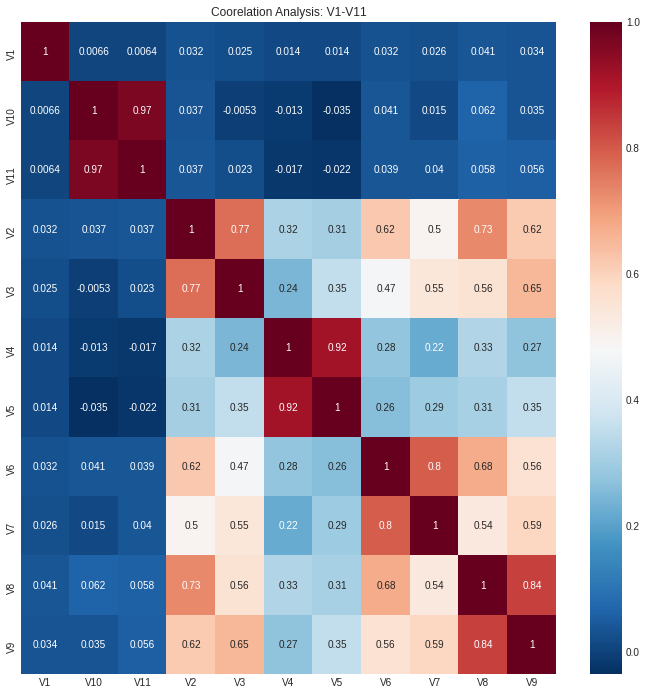

In [ ]:
cols = ['V3', 'V9', 'V5', 'V11', 'V10', 'V8', 'V7', 'V6', 'V4', 'V2', 'V1']
coorelation_analysis(cols,title='Coorelation Analysis: V1-V11')

In [ ]:
pairs = [['V1'],['V2','V3'],['V4','V5'],['V6','V7'],['V8','V9'],['V10','V11']]
reduce_groups(pairs)

['V1', 'V3', 'V4', 'V6', 'V8', 'V11']

## group2[V12 - V34]

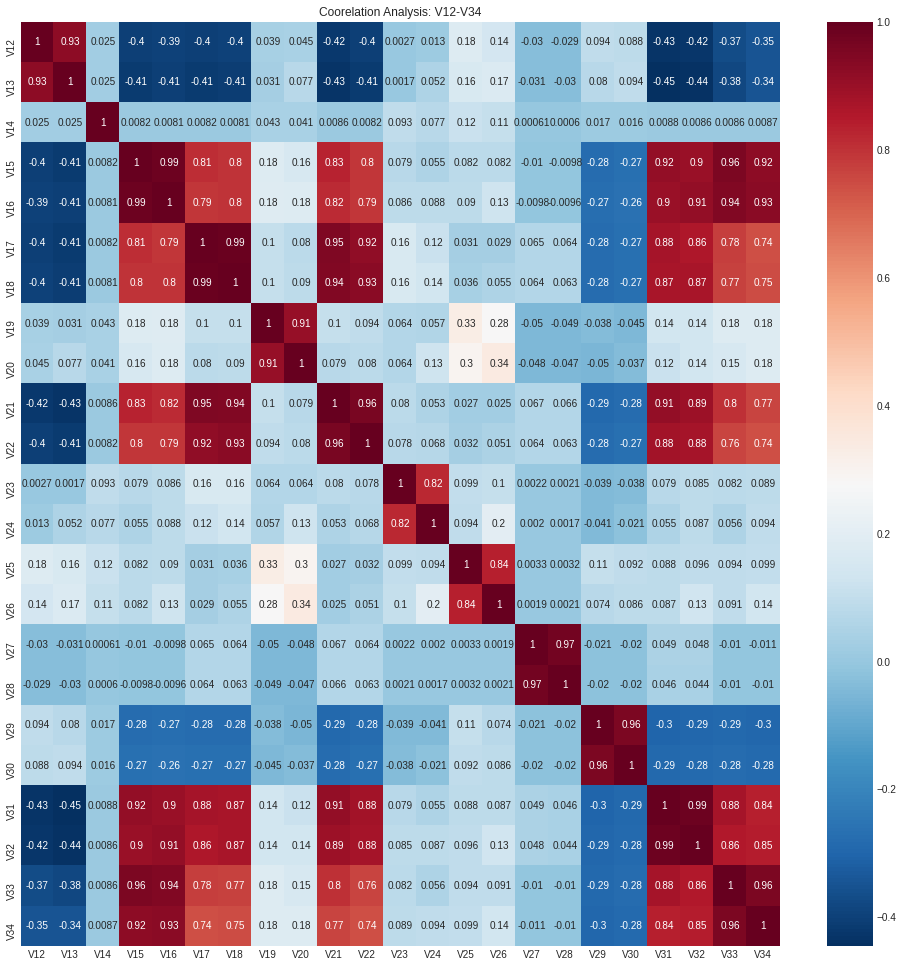

In [ ]:
cols = ['V21', 'V22', 'V23', 'V34', 'V33', 'V32','V31', 'V30', 'V29', 'V28', 
         'V27', 'V25', 'V24', 'V26', 'V16', 'V15', 
        'V20', 'V14', 'V19', 'V18', 'V17', 'V12', 'V13']

coorelation_analysis(cols,title='Coorelation Analysis: V12-V34',size=(17,17))


In [ ]:
pairs = [['V12','V13'],['V14'],['V15','V16','V17','V18','V21','V22','V31','V32','V33','V34'],['V19','V20'],
         ['V23','V24'],['V25','V26'],['V27','V28'],['V29','V30']]

red_cols = reduce_groups(pairs)
red_cols


['V13', 'V14', 'V17', 'V20', 'V23', 'V26', 'V27', 'V30']

## group3 [V35 - V52]

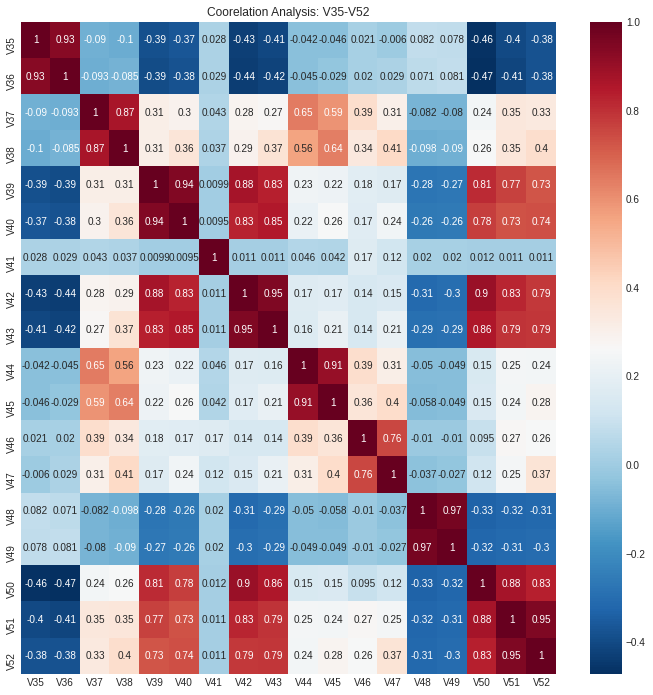

In [ ]:
cols = ['V35', 'V40', 'V41', 'V39', 'V38', 'V51', 'V37', 'V52', 'V36', 'V50', 'V48', 'V42',
 'V43', 'V44', 'V46', 'V47', 'V45', 'V49']


coorelation_analysis(cols,title='Coorelation Analysis: V35-V52',size=(12,12))


In [ ]:
pairs = [['V35','V36'],['V37','V38'],['V39','V40','V42','V43','V50','V51','V52'],['V41'],
         ['V44','V45'],['V46','V47'],['V48','V49']]

red_cols = reduce_groups(pairs)
red_cols


['V36', 'V37', 'V40', 'V41', 'V44', 'V47', 'V48']

## group4 [V52-V74]

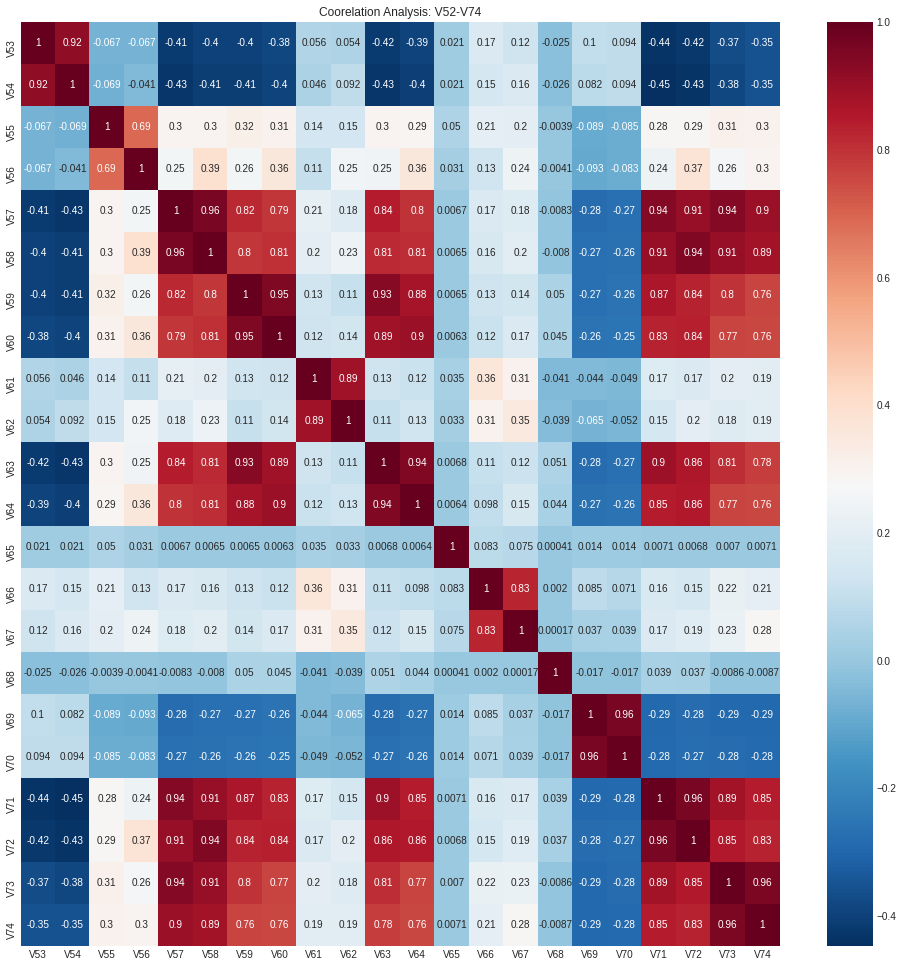

In [ ]:
cols = ['V72', 'V74', 'V73', 'V71', 'V65', 'V68', 'V58', 'V70', 'V53', 
 'V54', 'V55', 'V56', 'V57', 'V59', 'V67', 'V60', 'V61',
 'V62', 'V63', 'V64', 'V66', 'V69']

coorelation_analysis(cols,title='Coorelation Analysis: V52-V74',size=(17,17))


In [ ]:
pairs = [['V53','V54'],['V55'],['V56'],['V57', 'V58', 'V59', 'V60', 'V63', 'V64', 'V71', 'V72', 'V73', 'V74'],['V61','V62'],
 ['V65'],['V66','V67'],['V68'],['V69','V70']]



red_cols = reduce_groups(pairs)
red_cols


['V54', 'V55', 'V56', 'V59', 'V62', 'V65', 'V67', 'V68', 'V70']

## group5 [V75 - V94]

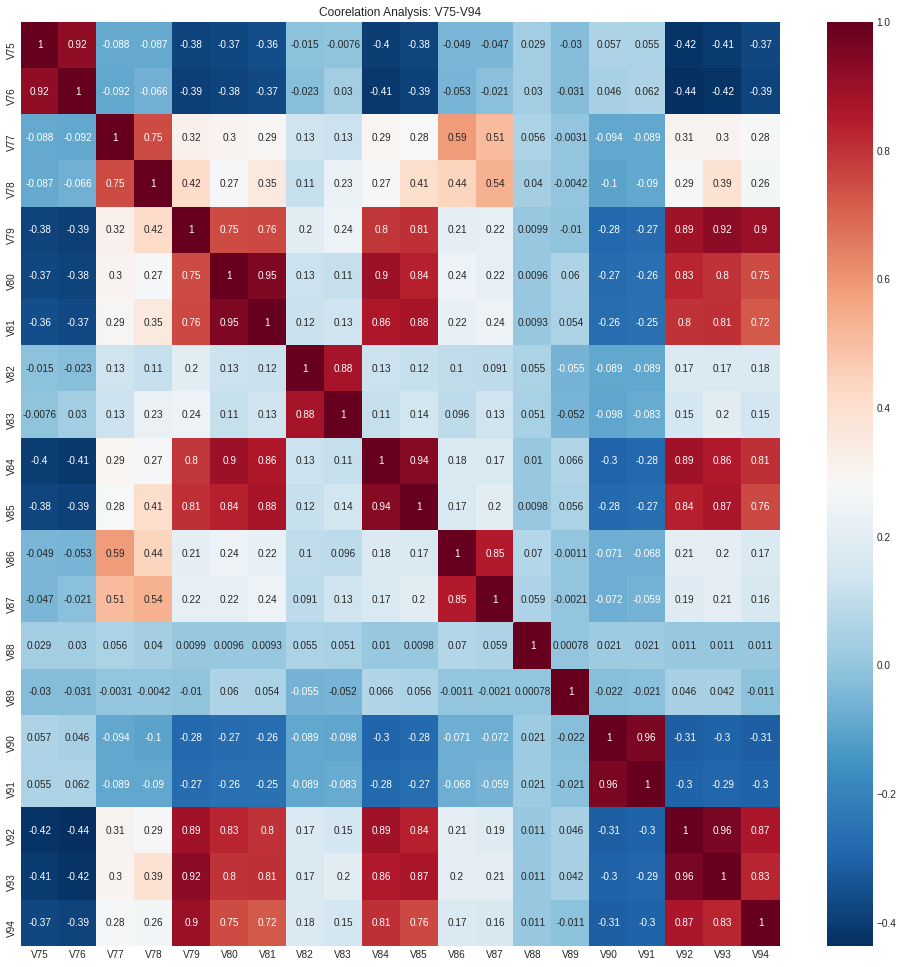

In [ ]:
cols = ['V80', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V86', 'V79',
 'V85', 'V75', 'V84', 'V77', 'V83', 'V78', 'V82', 'V81', 'V76']

coorelation_analysis(cols,title='Coorelation Analysis: V75-V94',size=(17,17))


In [ ]:
pairs = [['V75','V76'],['V77','V78'],['V79','V80','V81','V84','V85','V92','V93','V94'],['V82','V83'],['V86','V87'],
         ['V88'],['V89'],['V90','V91']]


red_cols = reduce_groups(pairs)
red_cols

['V76', 'V78', 'V80', 'V82', 'V86', 'V88', 'V89', 'V91']

## group6 [V95 - V137]

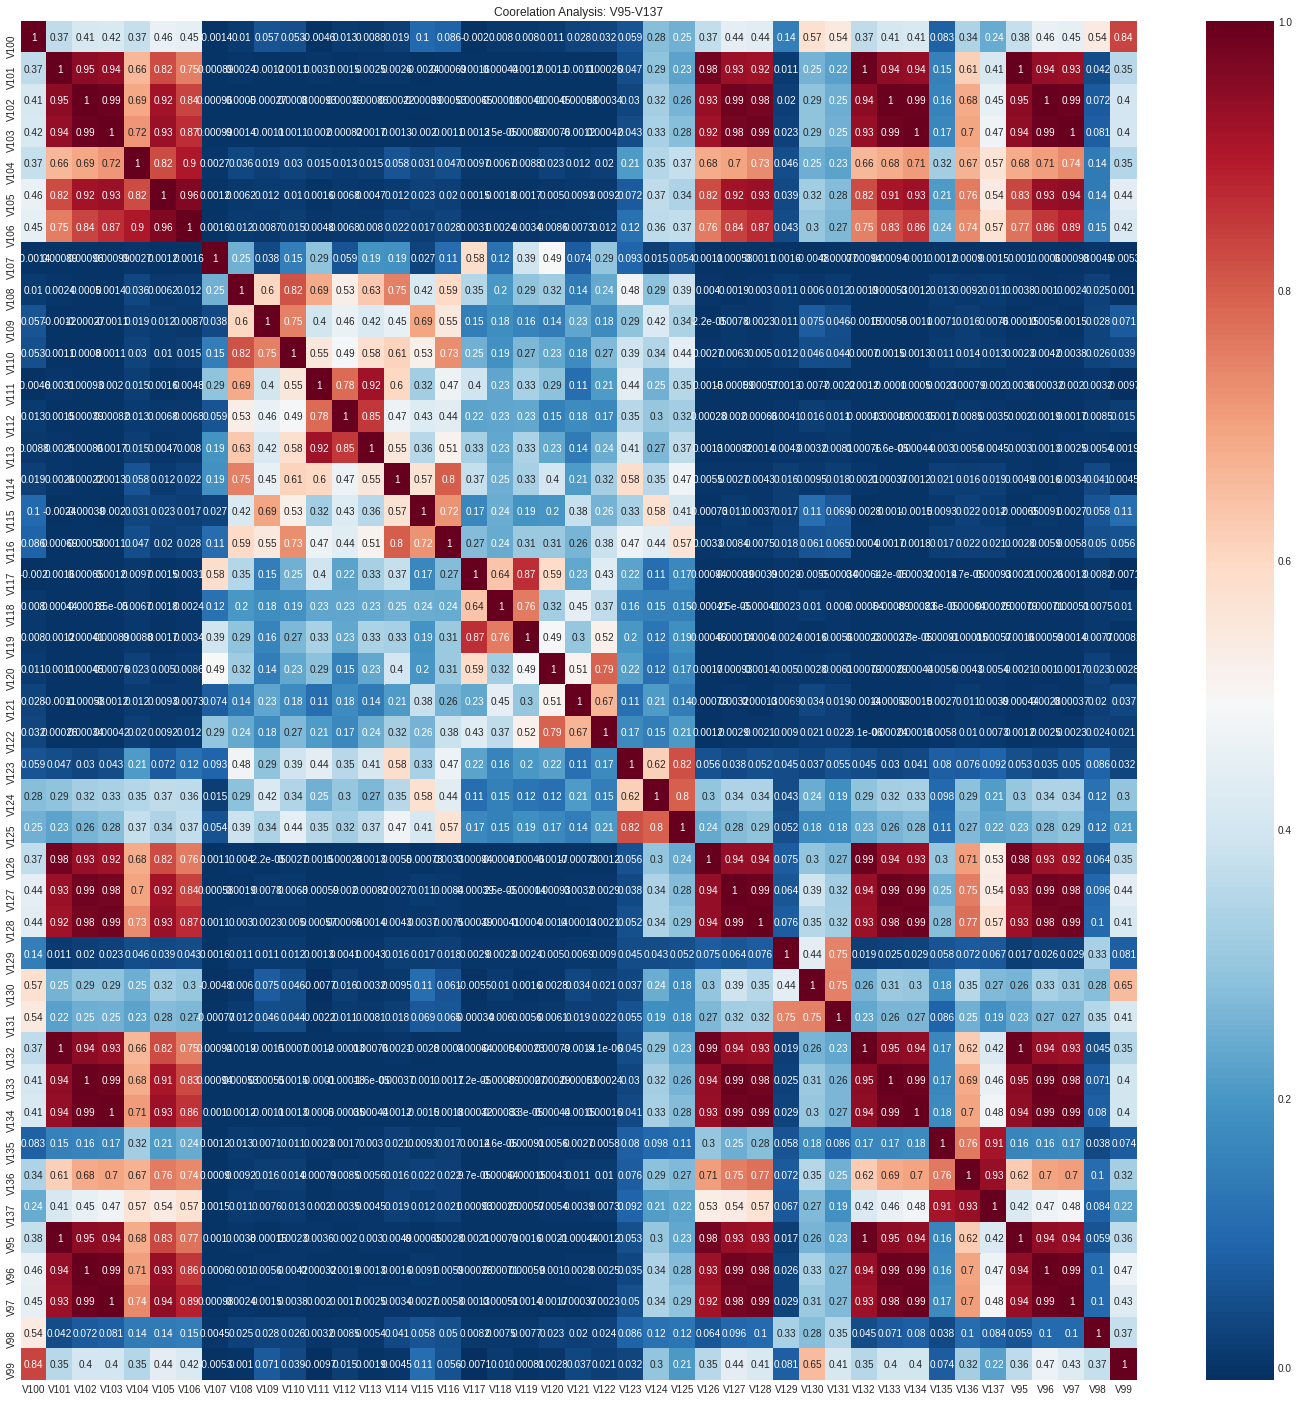

In [ ]:

cols = ['V104', 'V109', 'V110', 'V111', 'V112', 'V106', 'V105', 'V102', 'V103', 'V96', 'V101', 'V100',
        'V99', 'V98', 'V97', 'V95', 'V135', 'V134', 'V107', 'V133', 'V132', 'V131', 'V130', 'V129', 
        'V128', 'V127', 'V126', 'V125', 'V124', 'V123', 'V122', 'V121', 
        'V120', 'V119', 'V118', 'V117', 'V116', 'V115', 'V114', 'V113', 'V136', 'V137', 'V108']

coorelation_analysis(cols,title='Coorelation Analysis: V95-V137',size=(25,25))


* Here we have about 43 column. If we do coorelation analysis these as a whole, it can result in large groups and on reducing the number of columns will become so small.SO it may result in drop in our AUC score. So we further split this into 2 groups and then do coorelation analysis

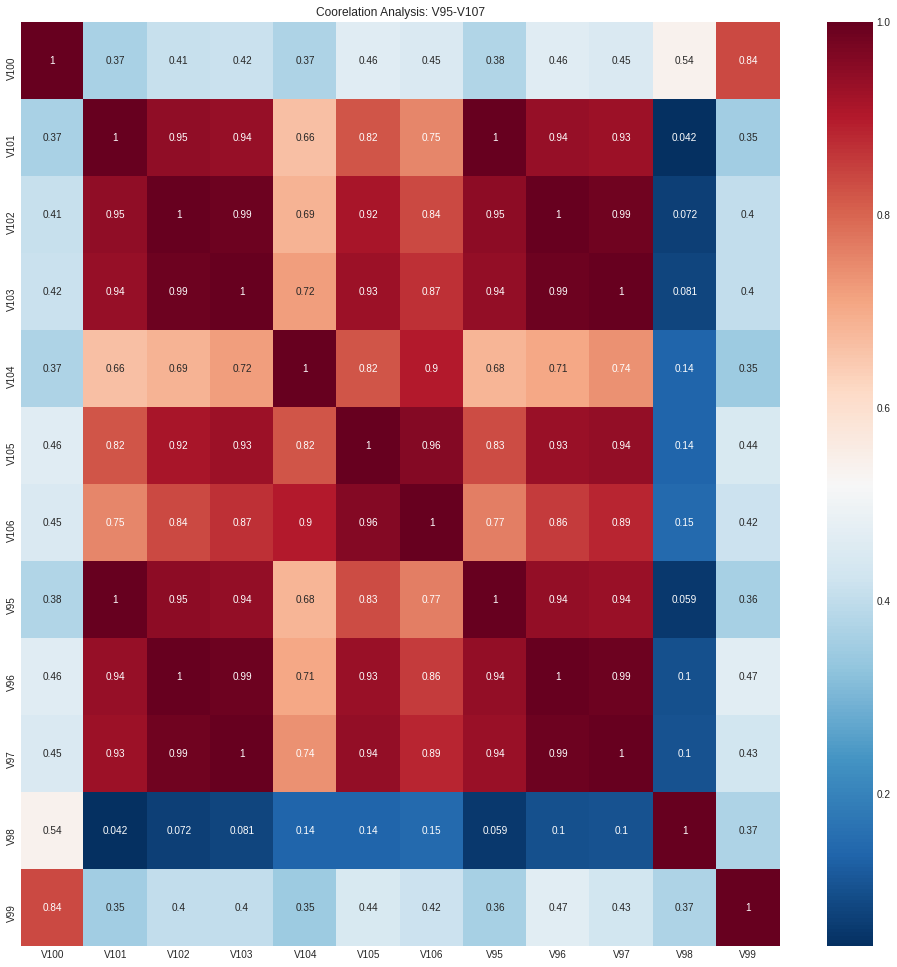

In [ ]:
cols = ['V'+str(x) for x in range(95,107)]

coorelation_analysis(cols,title='Coorelation Analysis: V95-V107',size=(17,17))

In [ ]:
pairs = [['V99','V100'],['V98'],['V104'],['V95','V96','V97','V101','V102','V103','V105','V106']]

red_cols = reduce_groups(pairs)
red_cols

['V99', 'V98', 'V104', 'V96']

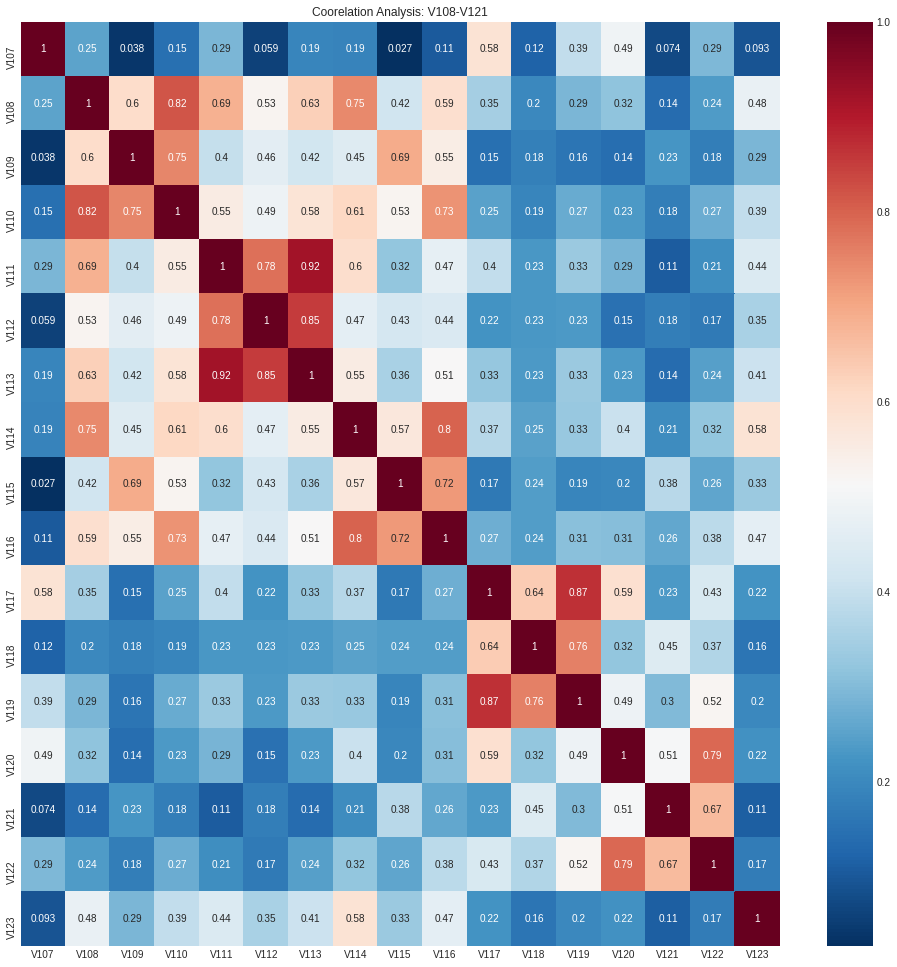

In [ ]:
cols = ['V'+str(x) for x in range(107,124)]

coorelation_analysis(cols,title='Coorelation Analysis: V108-V121',size=(17,17))

In [ ]:

pairs = [['V107'],['V108','V109','V110','V114'],['V111','V112','V113'],['V115','V116'],['V117','V118','V119'],['V120','V122'],['V121'],['V123']]

red_cols = reduce_groups(pairs)
red_cols

['V107', 'V108', 'V111', 'V115', 'V117', 'V120', 'V121', 'V123']

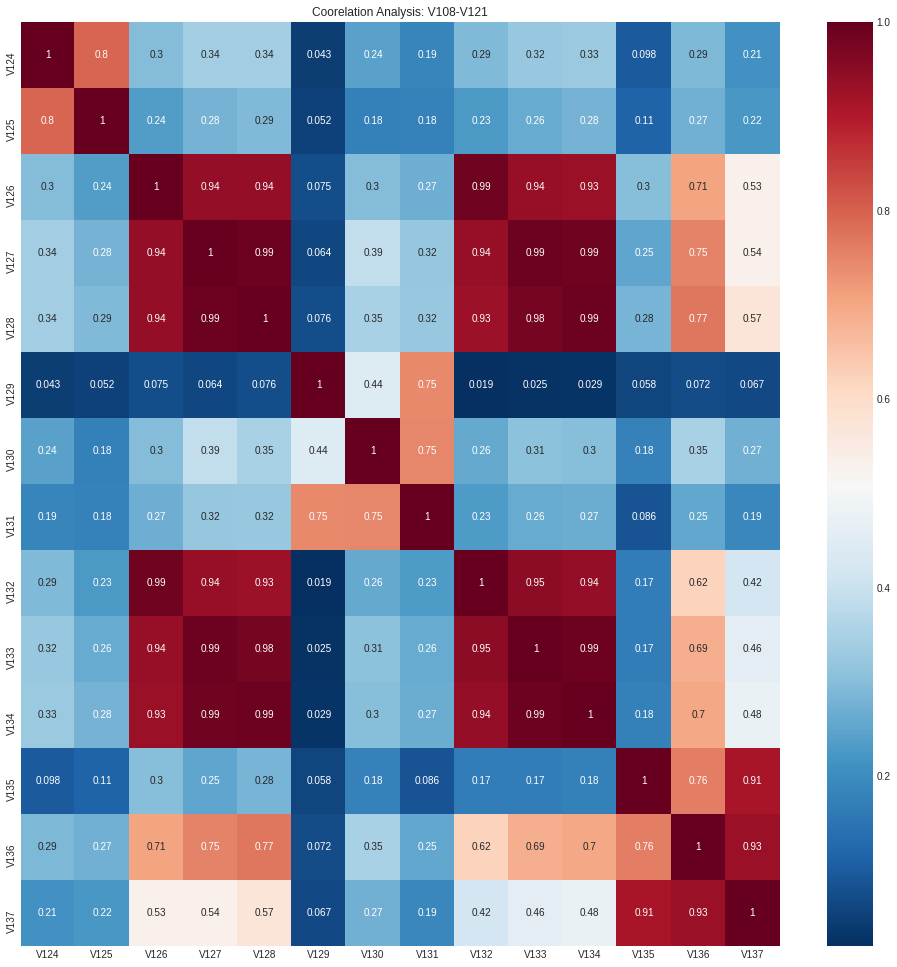

In [ ]:

cols = ['V'+str(x) for x in range(124,138)]
coorelation_analysis(cols,title='Coorelation Analysis: V108-V121',size=(17,17))

In [ ]:
pairs = [['V124','V125'],['V126','V127','V128','V132','V133','V134'],['V129'],['V130','V131'],['V135','V136','V137']]

red_cols = reduce_groups(pairs)
red_cols

['V124', 'V127', 'V129', 'V130', 'V136']

## group7 [V138 ~ V163]


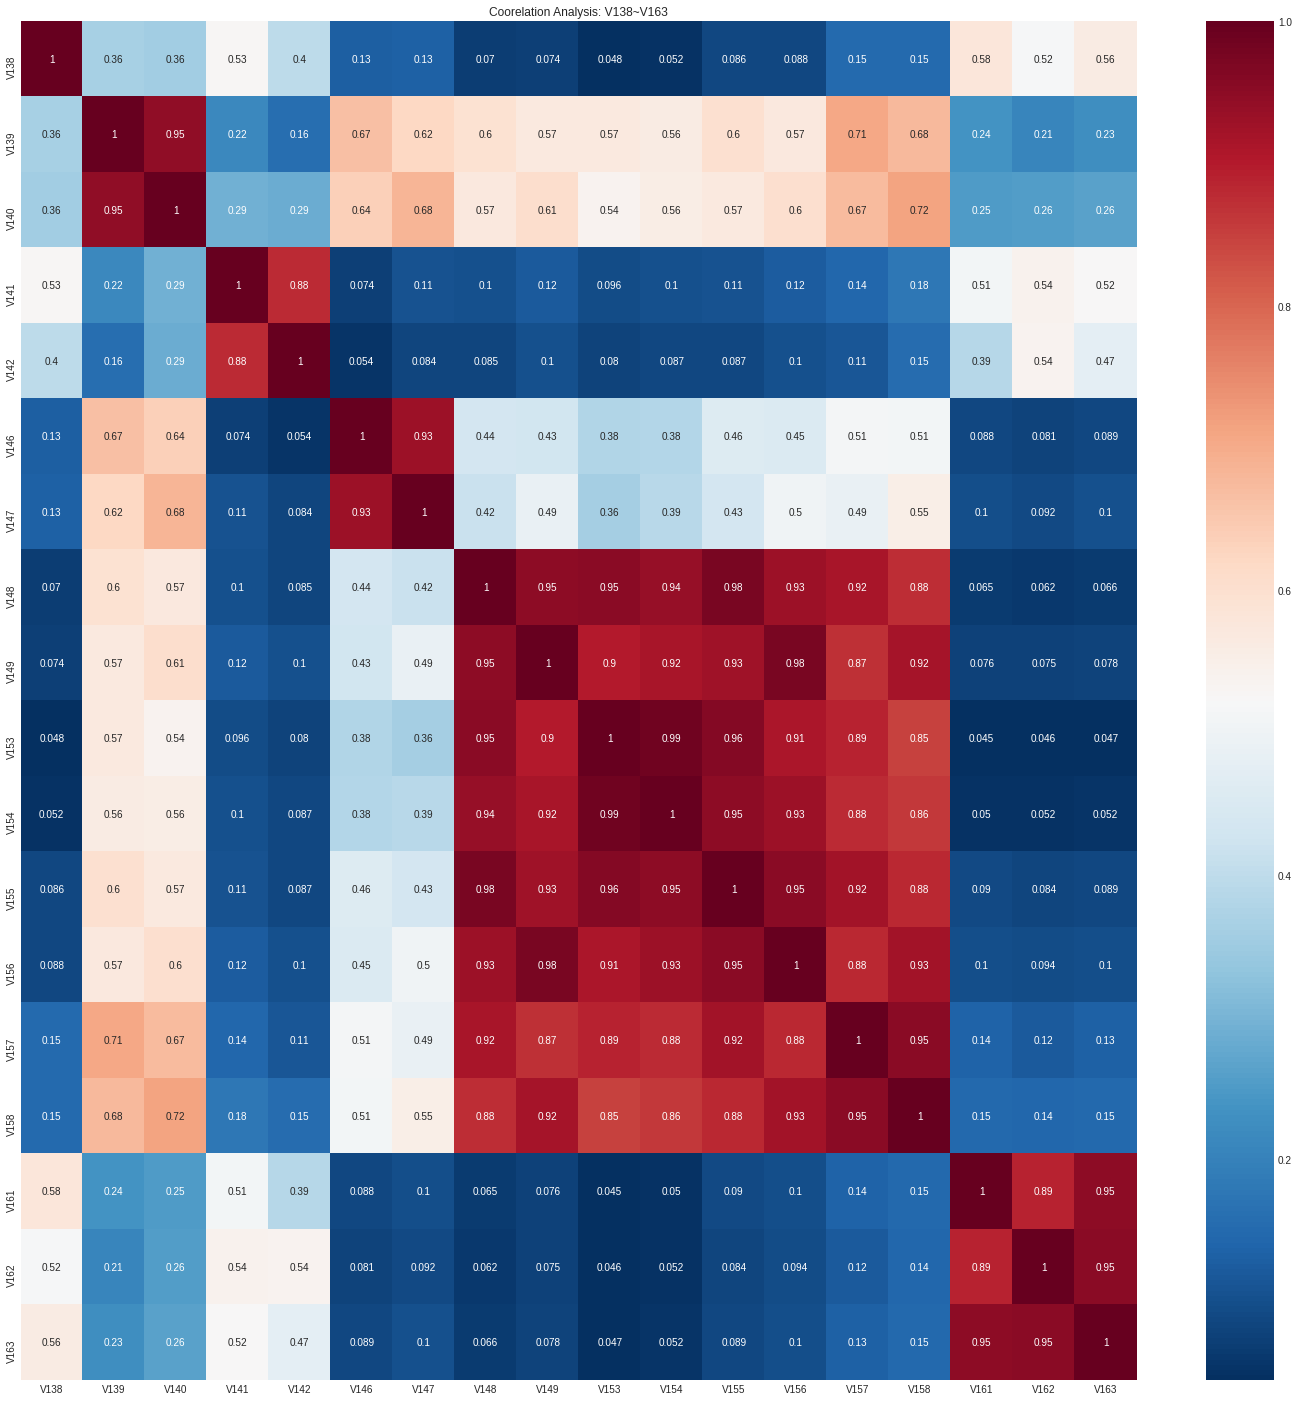

In [ ]:
cols = ['V142', 'V158', 'V140', 'V162', 'V141', 'V161', 'V157', 'V146', 'V156', 'V155', 'V154',
        'V153', 'V149', 'V147', 'V148', 'V163', 'V139', 'V138']

coorelation_analysis(cols,title='Coorelation Analysis: V138~V163',size=(25,25))


In [ ]:
pairs = [['V138'],['V139','V140'],['V141','V142'],['V146','V147'],['V148','V149','V153','V154','V156','V157','V158'],['V161','V162','V163']]

red_cols = reduce_groups(pairs)
red_cols

['V138', 'V139', 'V142', 'V147', 'V156', 'V162']

##  group8 [V143 ~ V166]

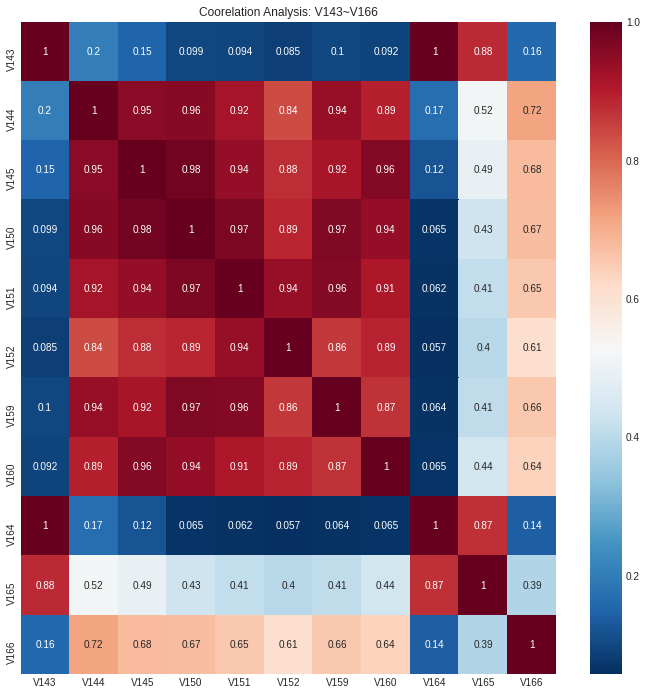

In [ ]:
cols = ['V160', 'V151', 'V152', 'V145', 'V144', 'V143', 'V159', 'V164', 'V165', 'V166', 'V150']

coorelation_analysis(cols,title='Coorelation Analysis: V143~V166',size=(12,12))


In [ ]:
pairs = [['V143','V164','V165'],['V144','V145','V150','V151','V152','V159','V160'],['V166']]

red_cols = reduce_groups(pairs)
red_cols

['V165', 'V160', 'V166']

## group9 [V167 ~ V216]

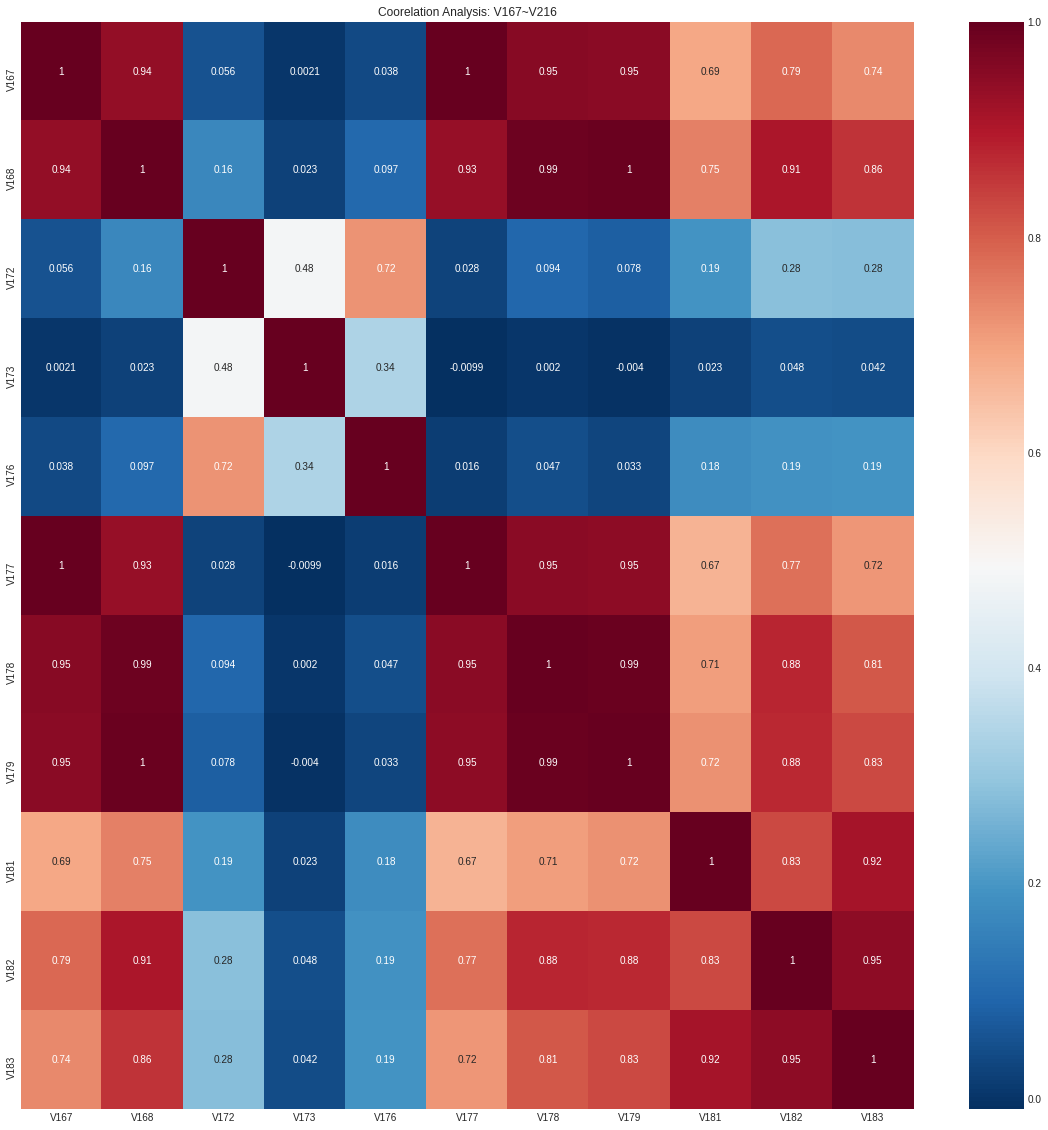

In [ ]:
cols = ['V167', 'V168','V172','V173','V176','V177','V178','V179','V181','V182','V183']

coorelation_analysis(cols,title='Coorelation Analysis: V167~V216',size=(20,20))

In [ ]:
pairs = [['V167','V168','V177','V178','V179'],['V172','V176'],['V173'],['V181','V182','V183']]
reduce_groups(pairs)


['V178', 'V176', 'V173', 'V182']

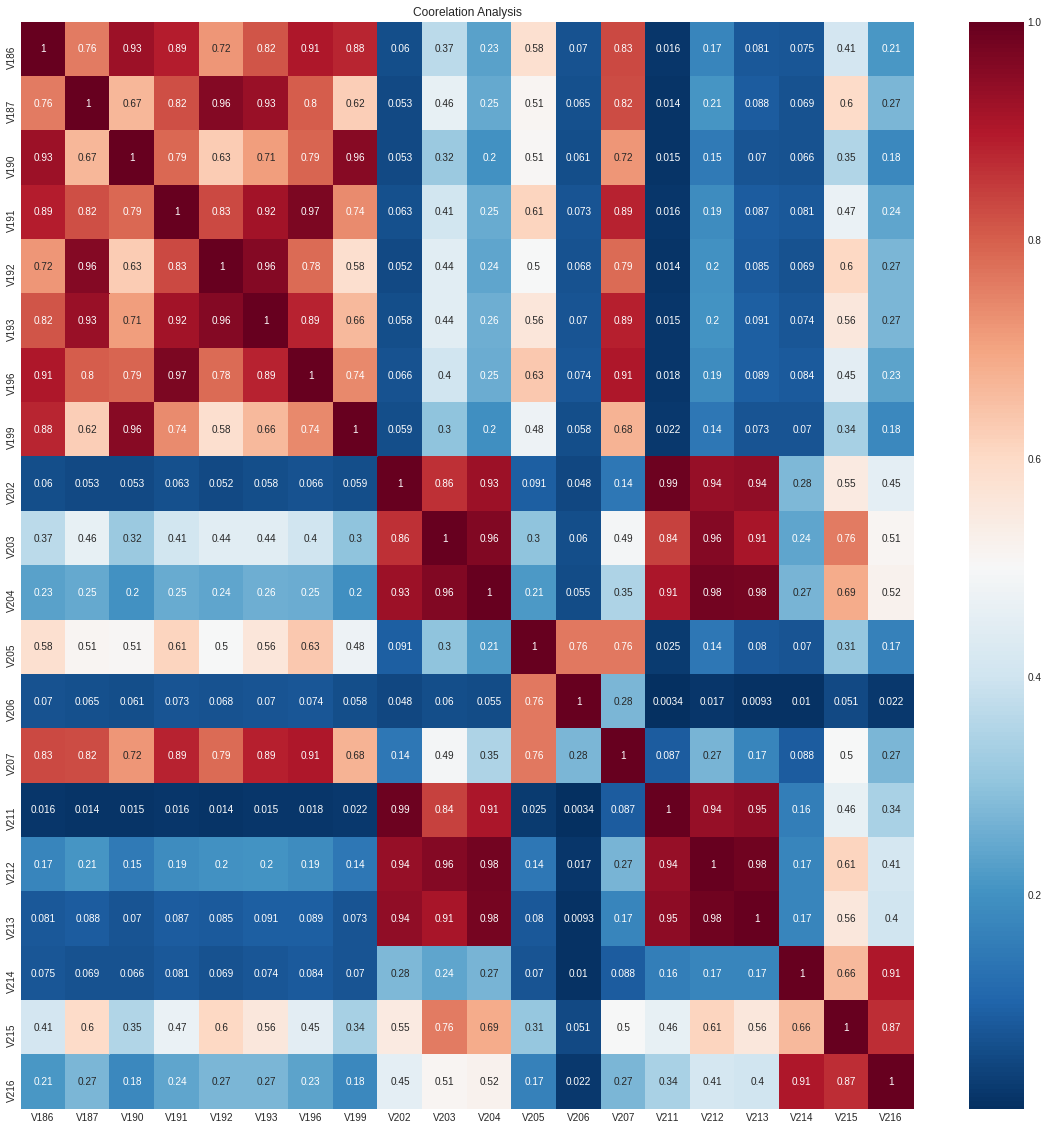

In [ ]:
cols = ['V186','V187','V190','V191','V192','V193','V196','V199','V202','V203','V204','V211','V212','V213','V205','V206','V207','V214','V215','V216']

coorelation_analysis(cols,title='Coorelation Analysis',size=(20,20))

In [ ]:
pairs = [['V186','V187','V190','V191','V192','V193','V196','V199'],['V202','V203','V204','V211','V212','V213'],['V205','V206'],['V207'],['V214','V215','V216']]
reduce_groups(pairs)


['V187', 'V203', 'V205', 'V207', 'V215']

## group10 [V169 ~ V210]

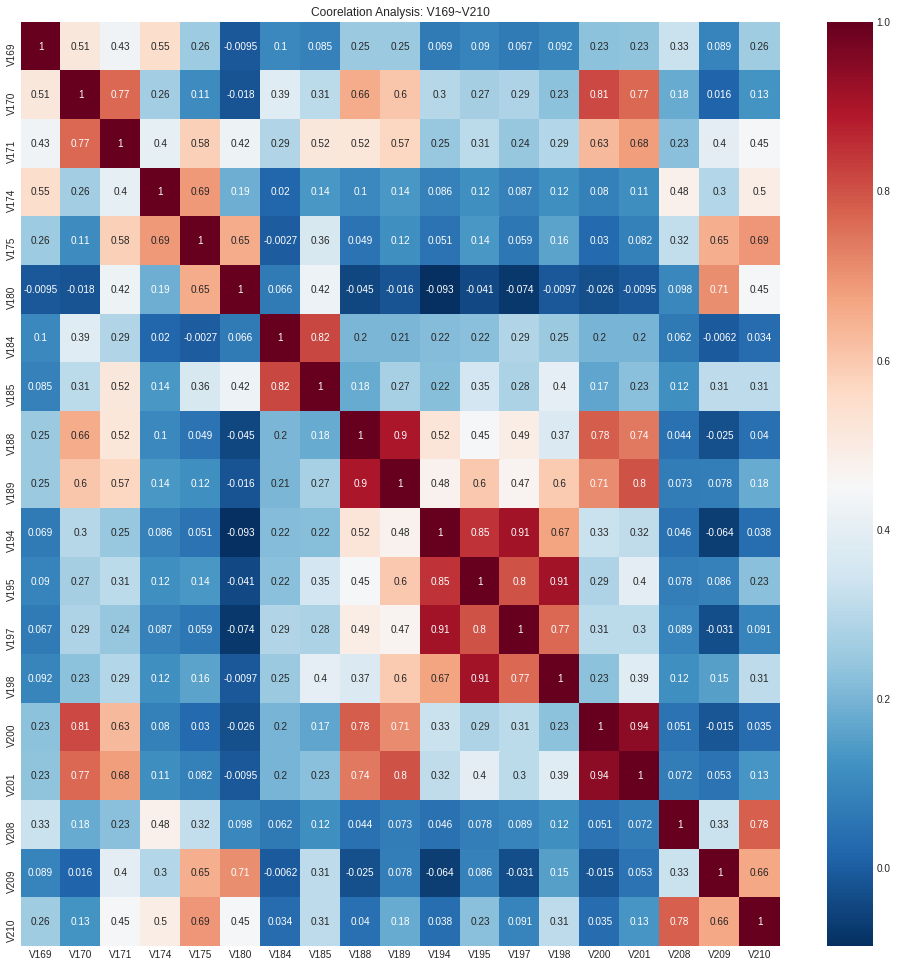

In [ ]:
cols = ['V194', 'V200', 'V189', 'V188', 'V185', 'V184', 'V180', 'V175', 'V174', 'V171',
 'V170', 'V169', 'V195', 'V201', 'V197', 'V198', 'V209', 'V208', 'V210']


coorelation_analysis(cols,title='Coorelation Analysis: V169~V210',size=(17,17))

In [ ]:
pairs = [['V169'],['V170','V171','V200','V201'],['V174','V175'],['V180'],['V184','V185'],['V188','V189'],['V194','V195','V197','V198'],['V208','V210'],
         ['V209']]

red_cols = reduce_groups(pairs)
red_cols

['V169', 'V171', 'V175', 'V180', 'V185', 'V188', 'V198', 'V210', 'V209']

## group11 [V217 ~ V278]

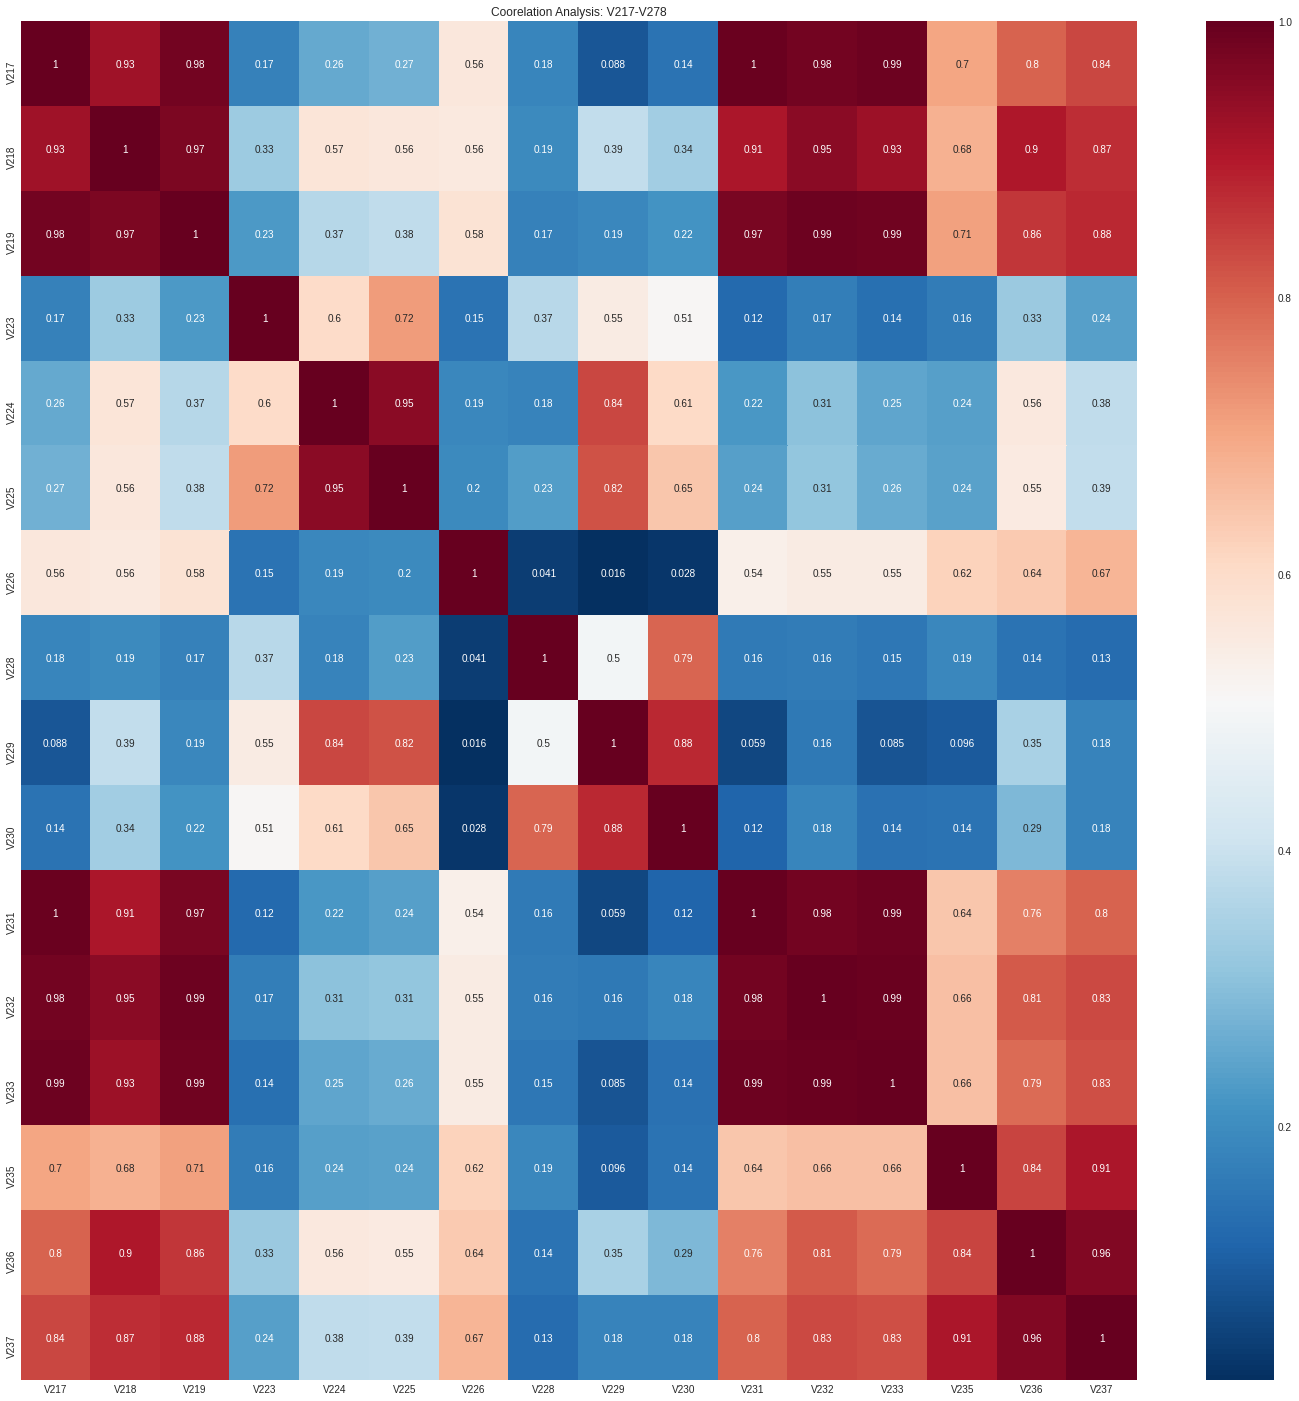

In [ ]:
cols = ['V217','V218','V219','V231','V232','V233','V236','V237','V223','V224','V225','V226','V228','V229','V230','V235']


coorelation_analysis(cols,title='Coorelation Analysis: V217-V278',size=(25,25))

In [ ]:
pairs = [['V217','V218','V219','V231','V232','V233','V236','V237'],['V223'],['V224','V225'],['V226'],['V228'],['V229','V230'],['V235']]
reduce_groups(pairs)



['V218', 'V223', 'V224', 'V226', 'V228', 'V229', 'V235']

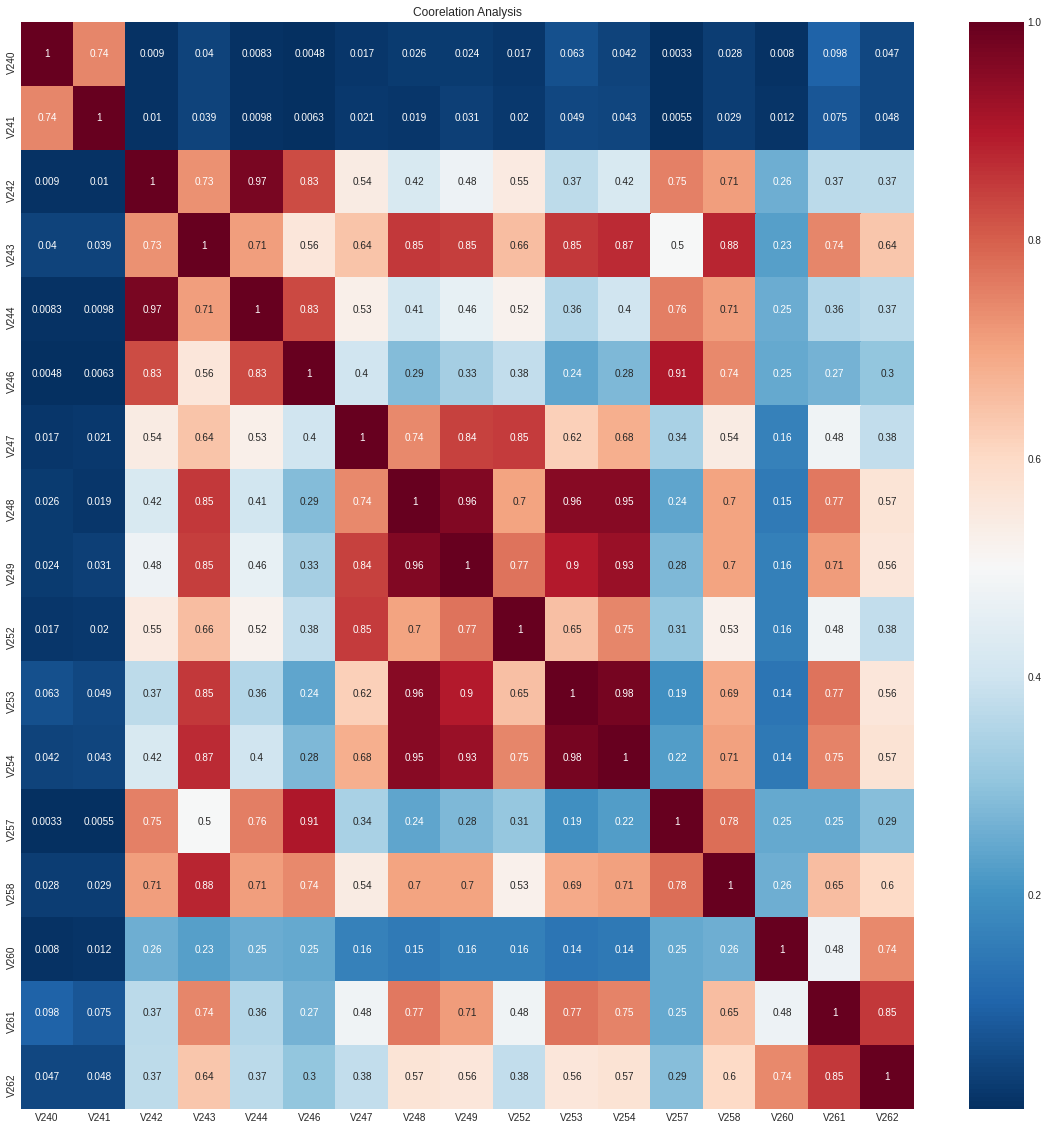

In [ ]:
cols = ['V240','V241','V242','V243','V244','V258','V246','V257','V247','V248','V249','V253','V254','V252','V260','V261','V262']

coorelation_analysis(cols,title='Coorelation Analysis',size=(20,20))

In [ ]:
pairs = [['V240','V241'],['V242','V243','V244','V258'],['V246','V257'],['V247','V248','V249','V253','V254'],['V252'],['V260'],['V261','V262']]

red_cols = reduce_groups(pairs)
red_cols

['V240', 'V258', 'V257', 'V253', 'V252', 'V260', 'V261']

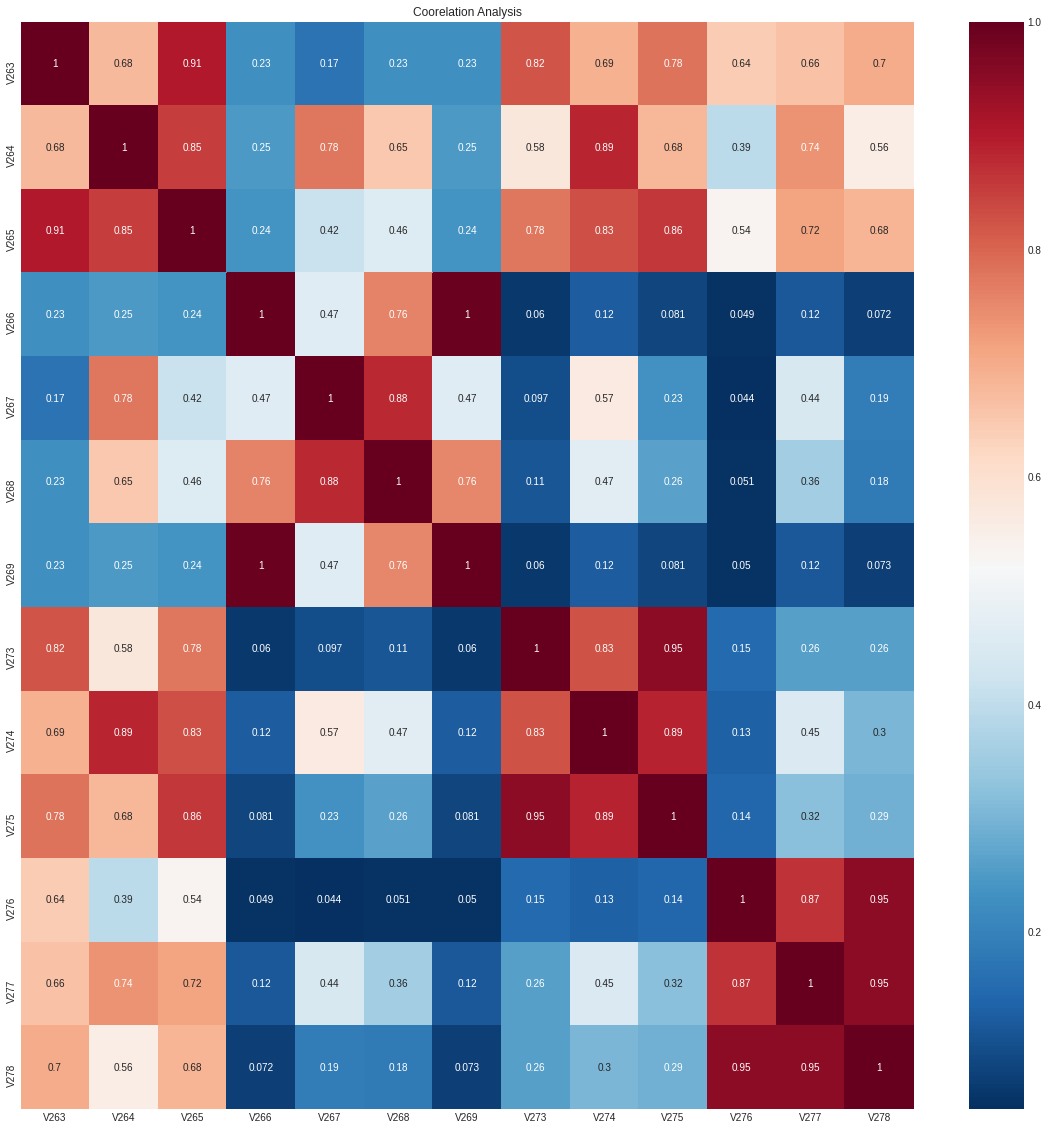

In [ ]:
cols =  ['V263','V265','V264','V266','V269','V267','V268','V273','V274','V275','V276','V277','V278']

coorelation_analysis(cols,title='Coorelation Analysis',size=(20,20))

In [ ]:
pairs =[['V263','V265','V264'],['V266','V269'],['V267','V268'],['V273','V274','V275'],['V276','V277','V278']]

reduce_groups(pairs)


['V264', 'V266', 'V267', 'V274', 'V277']

## group12 [V220 ~ V272]

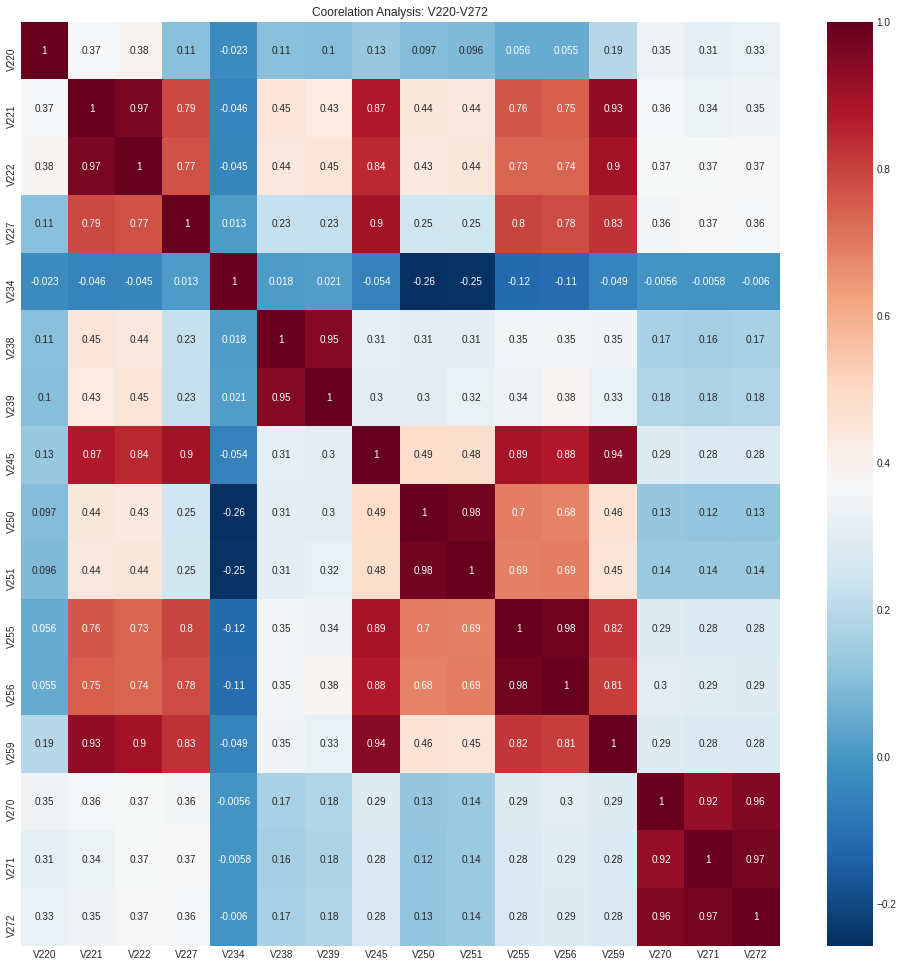

In [ ]:
cols = ['V245', 'V271', 'V234', 'V222', 'V238', 'V239', 'V227', 'V250', 
 'V272', 'V270', 'V251', 'V220', 'V255', 'V256', 'V259', 'V221']

coorelation_analysis(cols,title='Coorelation Analysis: V220-V272',size=(17,17))


In [ ]:
pairs = [['V220'],['V221','V222','V227','V245','V255','V256','V259'],['V234'],['V238','V239'],
         ['V250','V251'],['V270','V271','V272']]

reduce_groups(pairs)


['V220', 'V221', 'V234', 'V238', 'V250', 'V271']

## group13 [V279 ~ V321]

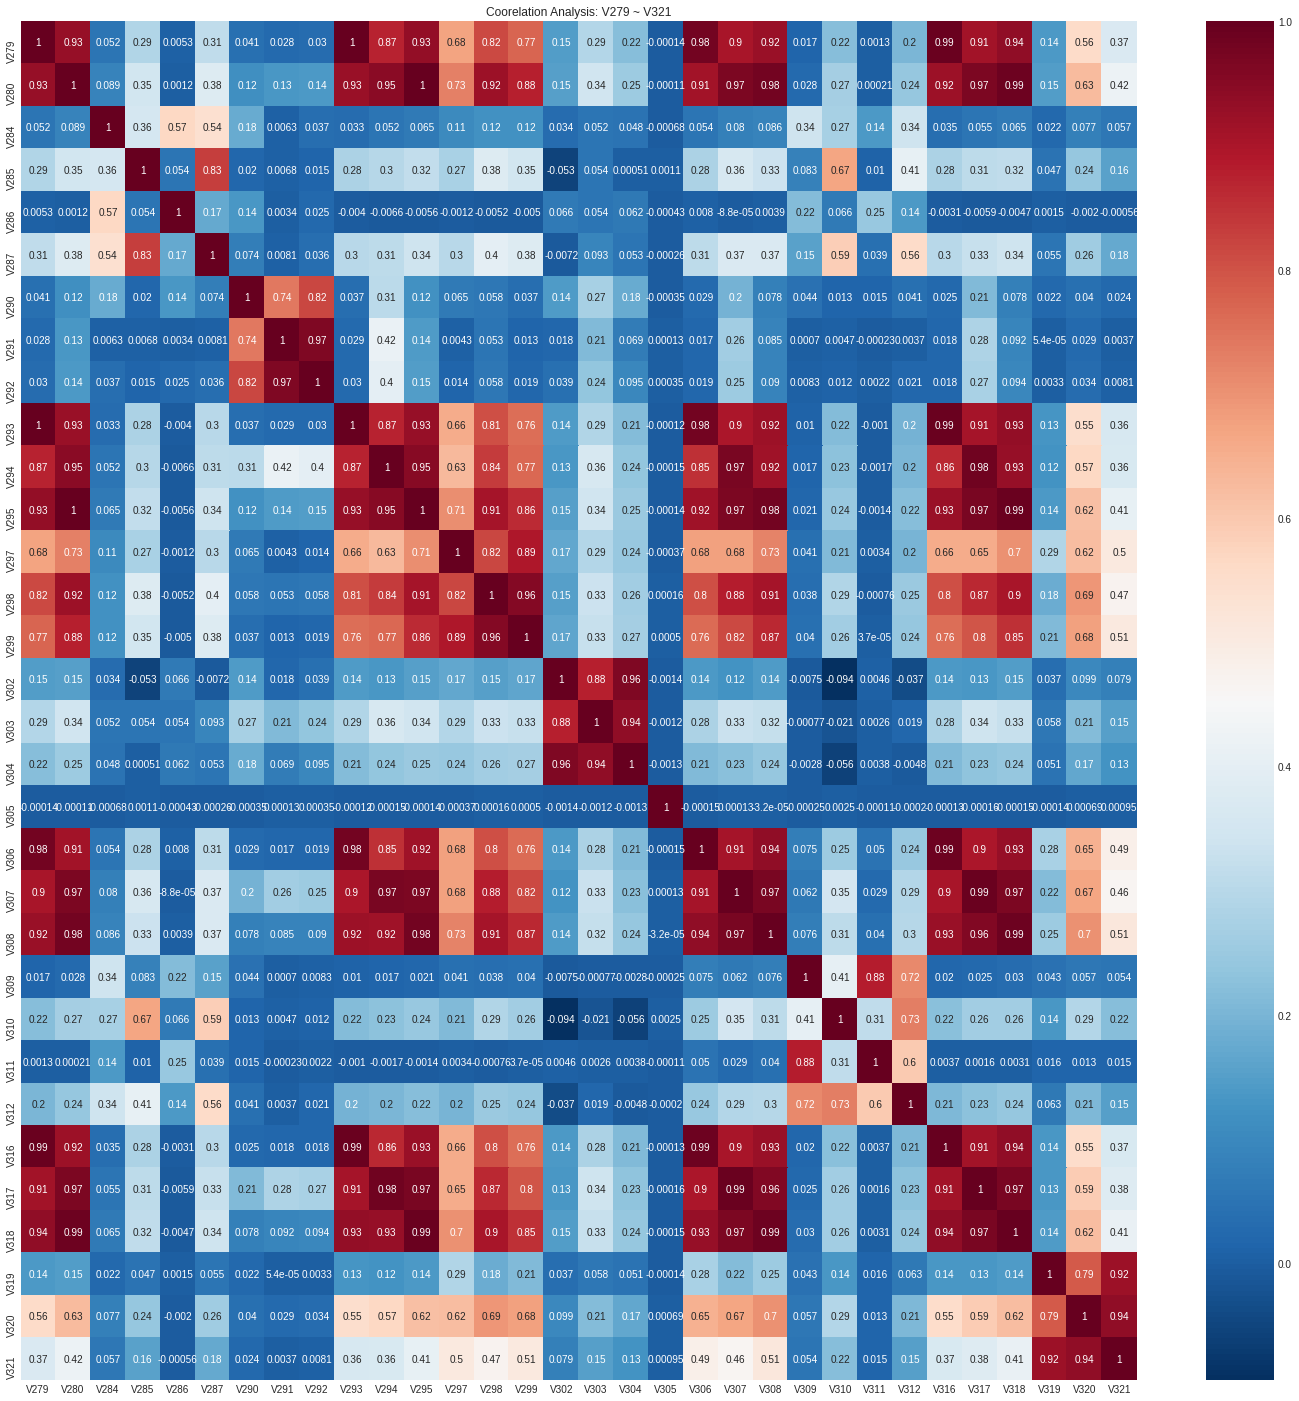

In [ ]:
cols = ['V311', 'V321', 'V294', 'V306', 'V305', 'V304', 'V303', 'V302', 'V299', 'V298', 'V297', 'V295', 
        'V293', 'V308', 'V292', 'V291', 'V290', 'V287', 'V286', 'V285', 'V284', 'V280', 'V279', 
        'V320', 'V307', 'V309', 'V312', 'V316', 'V317', 'V318', 'V319', 'V310']


coorelation_analysis(cols,title='Coorelation Analysis: V279 ~ V321',size=(25,25))


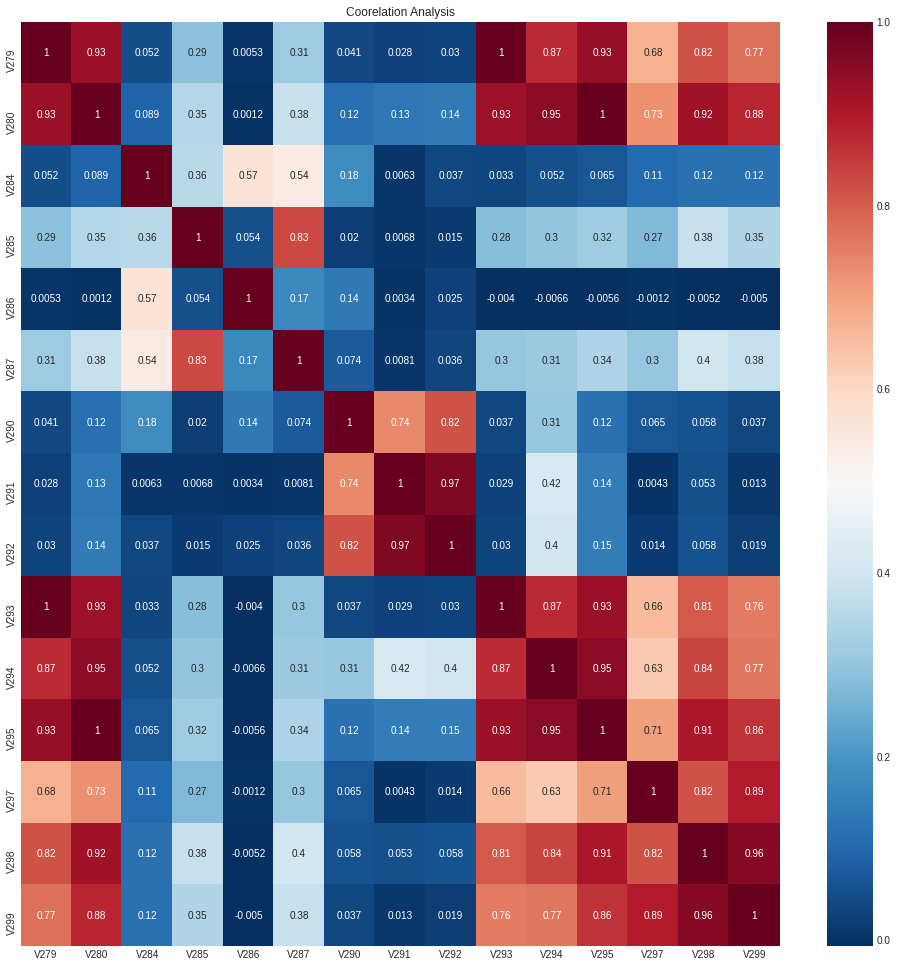

In [ ]:
cols = ['V279','V280','V293','V294','V295','V298','V299','V284','V285','V287','V286','V290','V291','V292','V297']

coorelation_analysis(cols,title='Coorelation Analysis',size=(17,17))

In [ ]:
pairs = [['V279','V280','V293','V294','V295','V298','V299'],['V284'],['V285','V287'],['V286'],['V290','V291','V292'],['V297']]

reduce_groups(pairs)



['V294', 'V284', 'V285', 'V286', 'V291', 'V297']

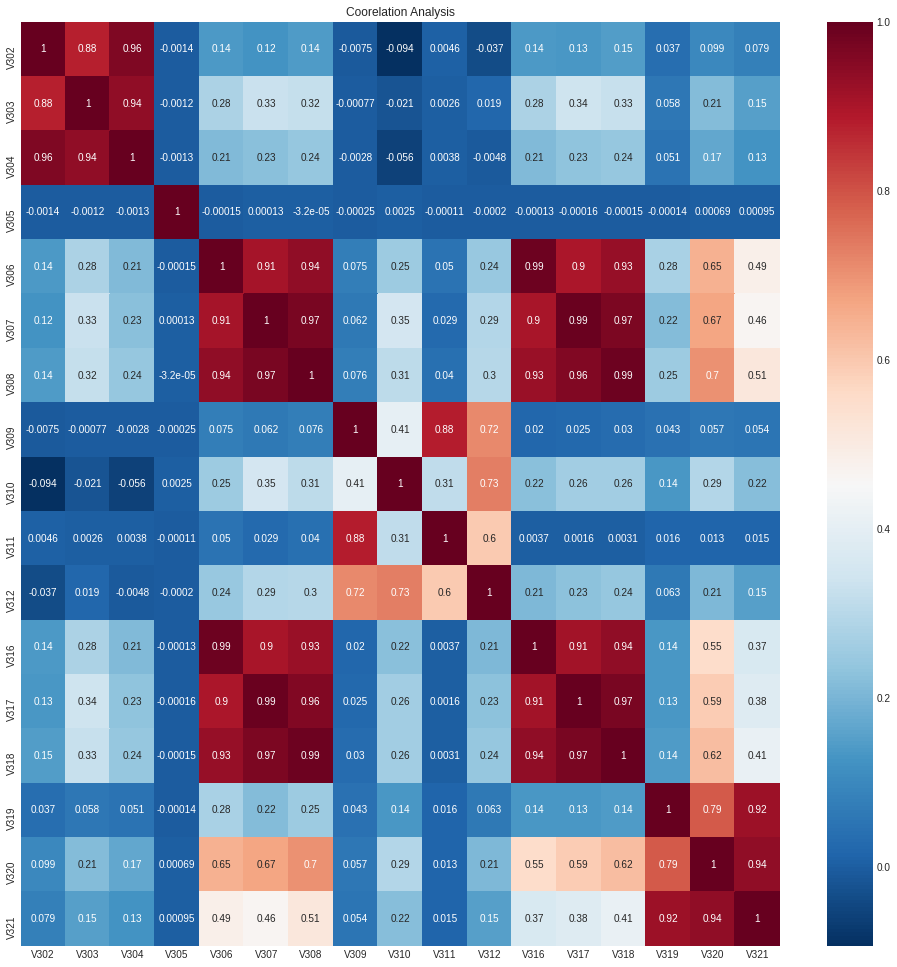

In [ ]:
cols = ['V302','V303','V304','V305','V306','V307','V308','V316','V317','V318','V309','V311','V310','V312','V319','V320','V321']

coorelation_analysis(cols,title='Coorelation Analysis',size=(17,17))

In [ ]:
pairs = [['V302','V303','V304'],['V305'],['V306','V307','V308','V316','V317','V318'],['V309','V311'],['V310','V312'],['V319','V320','V321']]
red_cols = reduce_groups(pairs)
red_cols

['V303', 'V305', 'V307', 'V309', 'V310', 'V320']

## group14 [V281-V313]

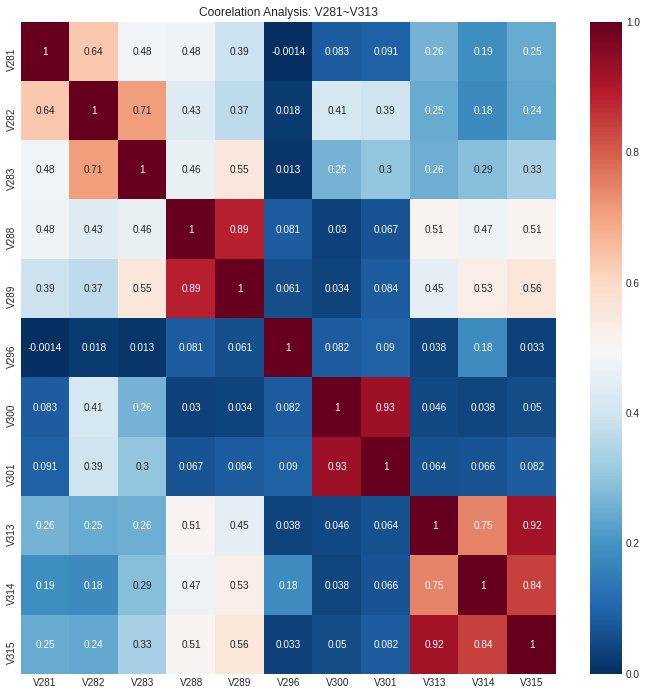

In [ ]:
cols = ['V296', 'V289', 'V288', 'V283', 'V282', 'V281', 'V300', 'V301', 'V313', 'V314', 'V315']

coorelation_analysis(cols,title='Coorelation Analysis: V281~V313',size=(12,12))


In [ ]:
pairs = [['V281'],['V282','V283'],['V288','V289'],['V296'],['V300','V301'],['V313','V314','V315']]

reduce_groups(pairs)


['V281', 'V283', 'V289', 'V296', 'V301', 'V314']

## group15 [V322 - V339]

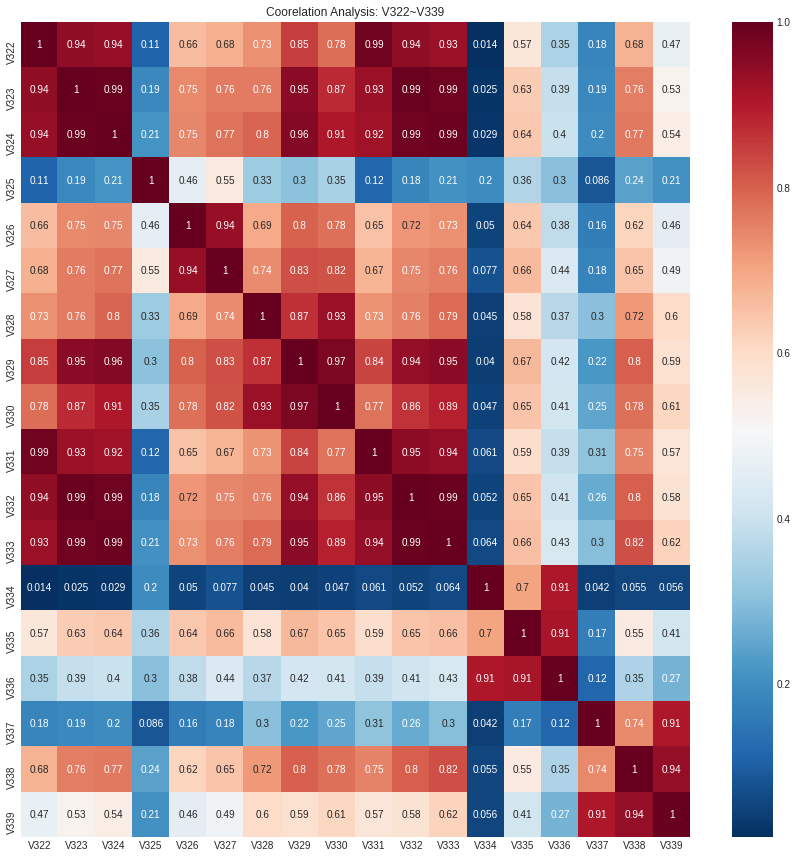

In [ ]:
cols = ['V337', 'V333', 'V336', 'V335', 'V334', 'V338', 'V339', 'V324',
 'V332', 'V325', 'V330', 'V329', 'V328', 'V327', 'V326', 'V322', 'V323', 'V331']

coorelation_analysis(cols,title='Coorelation Analysis: V322~V339',size=(15,15))


In [ ]:
pairs = [['V322','V323','V324','V326','V327','V328','V329','V330','V331','V332','V333'],['V325'],
         ['V334','V335','V336'],['V337','V338','V339']]

reduce_groups(pairs)


['V332', 'V325', 'V335', 'V338']

In [ ]:
reduced_vcols = ['V1', 'V3', 'V4', 'V6', 'V8', 'V11', 'V13', 'V14', 'V17', 'V20', 
 'V23', 'V26', 'V27', 'V30', 'V36', 'V37', 'V40', 'V41', 'V44', 'V47', 'V48', 'V54', 'V56', 'V59', 
 'V62', 'V65', 'V67', 'V68', 'V70', 'V76', 'V78', 'V80', 'V82', 'V86', 'V88', 'V89', 'V91', 'V96', 
 'V98', 'V99', 'V104', 'V107', 'V108', 'V111', 'V115', 'V117', 'V120', 'V121', 'V123', 'V124', 'V127', 
 'V129', 'V130', 'V136', 'V138', 'V139', 'V142', 'V147', 'V156', 'V162', 'V165', 'V160', 'V166', 'V178',
 'V176', 'V173', 'V182', 'V187', 'V203', 'V205', 'V207', 'V215', 'V169', 'V171', 'V175', 'V180', 'V185', 
 'V188', 'V198', 'V210', 'V209', 'V218', 'V223', 'V224', 'V226', 'V228', 'V229', 'V235', 'V240', 'V258', 
 'V257', 'V253', 'V252', 'V260', 'V261', 'V264', 'V266', 'V267', 'V274', 'V277', 'V220', 'V221', 'V234', 
 'V238', 'V250', 'V271', 'V294', 'V284', 'V285', 'V286', 'V291',
 'V297', 'V303', 'V305', 'V307', 'V309', 'V310', 'V320', 'V281', 'V283', 'V289', 'V296', 'V301', 'V314', 'V332', 'V325', 'V335', 'V338']

In [ ]:
fig,axes = plt.subplots(1,1,figsize=(25,25))
df_corr = df_train[reduced_v_cols].corr()
sns.heatmap(df_corr,annot=True,cmap='RdBu_r')
axes.title.set_text('Coorelation plot')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

* We can see that for few elements still a strong coorelation exists. But its few. Anyway we have reduced number of V colums to more than 50%.Let us see condition of other columns

## Coorelation analysis on id columns

In [ ]:
id_cols = [col for col in df_train.columns if col[0]+col[1] == 'id']
df_train[id_cols].head()

id_01    id_02  id_03  id_04  id_05  id_06  id_07  id_08  id_09  id_10  \
0    NaN      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1    NaN      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2    NaN      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3    NaN      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4    0.0  70787.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

   ...     id_29        id_30                id_31  id_32      id_33  \
0  ...       NaN          NaN                  NaN    NaN        NaN   
1  ...       NaN          NaN                  NaN    NaN        NaN   
2  ...       NaN          NaN                  NaN    NaN        NaN   
3  ...       NaN          NaN                  NaN    NaN        NaN   
4  ...  NotFound  Android 7.0  samsung browser 6.2   32.0  2220x1080   

            id_34  id_35  id_36  id_37  id_38  
0             NaN    NaN    NaN    NaN    NaN  
1             NaN    NaN    NaN    NaN    NaN  
2             NaN    NaN    NaN    NaN    NaN  
3             NaN    NaN    NaN    NaN    NaN  
4  match_status:2      T      F      T      T  

[5 rows x 38 columns]

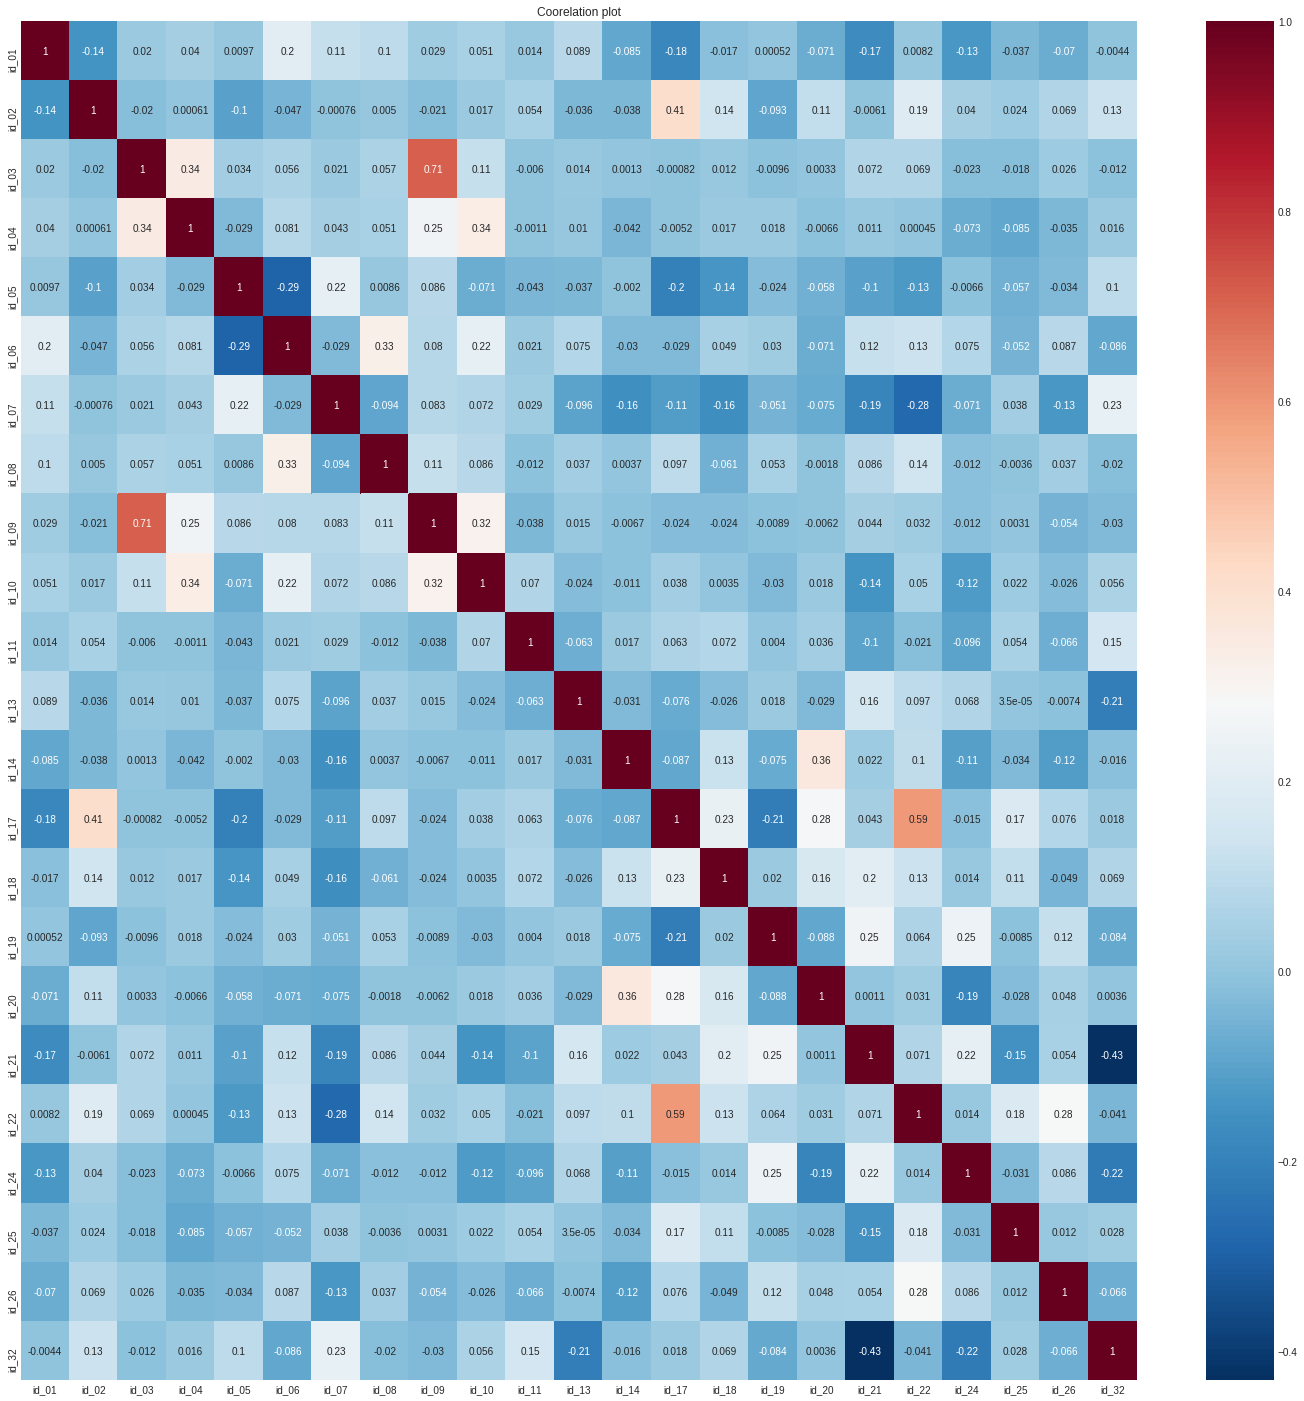

In [ ]:
fig,axes = plt.subplots(1,1,figsize=(25,25))
df_corr = df_train[id_cols].corr()
sns.heatmap(df_corr,annot=True,cmap='RdBu_r')
axes.title.set_text('Coorelation plot')
plt.show()

* We can see that there is not much of a strong coorelation between id columns

## Coorelation analysis on M columns

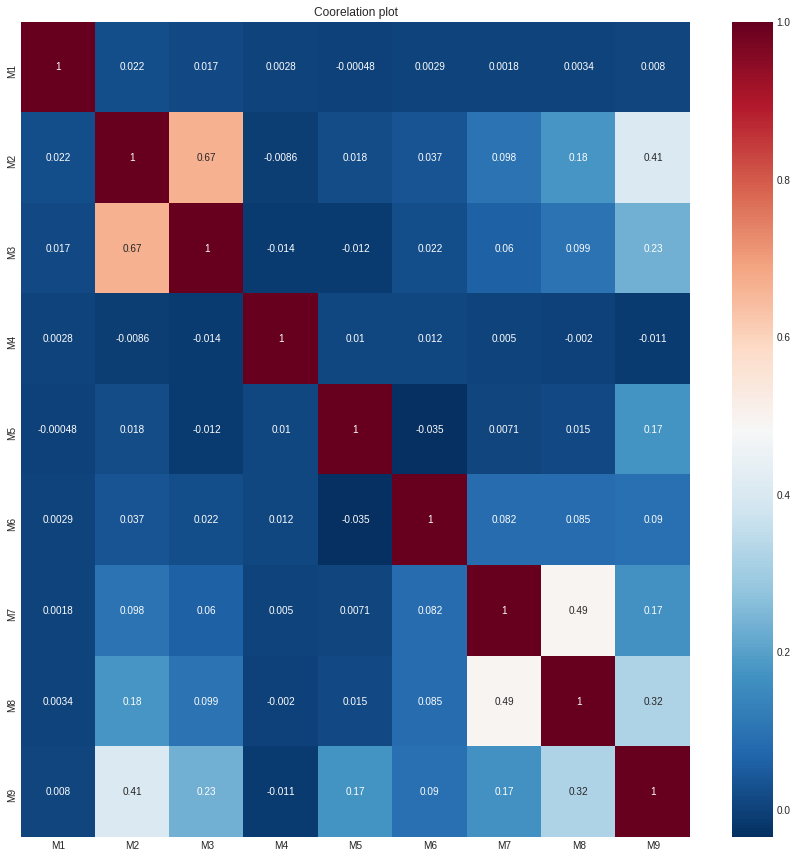

In [ ]:
m_cols = [col for col in df_train.columns if col[0] == 'M']

mp = {'F':0,'T':1,'M0':0,'M1':1,'M2':2}
for c in m_cols: df_train[c] = df_train[c].map(mp)

fig,axes = plt.subplots(1,1,figsize=(15,15))
df_corr = df_train[m_cols].corr()
sns.heatmap(df_corr,annot=True,cmap='RdBu_r')
axes.title.set_text('Coorelation plot')
plt.show()

## Coorelation analysis on D columns

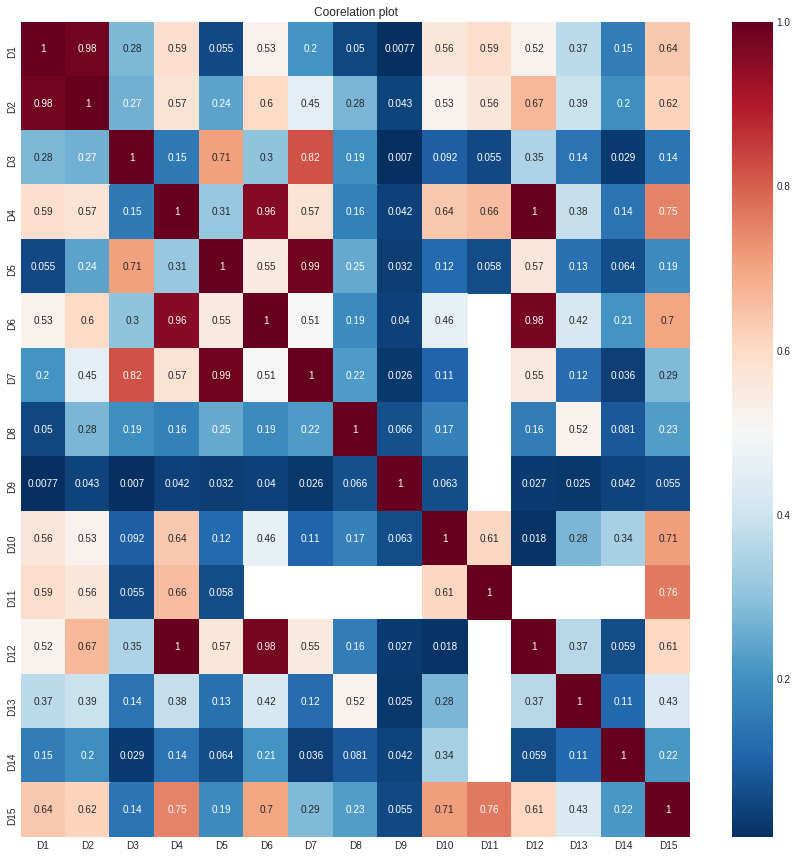

In [ ]:
d_cols = [col for col in df_train.columns if col[0] == 'D']

# mp = {'F':0,'T':1,'M0':0,'M1':1,'M2':2}
# for c in m_cols: df_train[c] = df_train[c].map(mp)

fig,axes = plt.subplots(1,1,figsize=(15,15))
df_corr = df_train[d_cols].corr()
sns.heatmap(df_corr,annot=True,cmap='RdBu_r')
axes.title.set_text('Coorelation plot')
plt.show()

## Model with reduced V cols

In [ ]:
# column details
cat_cols = (['ProductCD'] + 
            ['card%d' % i for i in range(1, 7)] + 
            ['addr1', 'addr2', 'P_emaildomain', 'R_emaildomain'] + 
            ['M%d' % i for i in range(1, 10)] + 
            ['DeviceType', 'DeviceInfo'] +
            ['id_%d' % i for i in range(12, 39)])


type_map = {c: str for c in cat_cols}
df_train[cat_cols] = df_train[cat_cols].astype(type_map, copy=False)
df_test[cat_cols] = df_test[cat_cols].astype(type_map, copy=False)

######################################################################################

id_cols = ['TransactionID', 'TransactionDT']
target = 'isFraud'

numeric_cols =  [
    'TransactionAmt', 'dist1', 'dist2', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 
    'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 
    'D12', 'D13', 'D14', 'D15', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 
    'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 
    'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 
    'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 
    'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 
    'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 
    'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 
    'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 
    'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 
    'V121', 'V122', 'V123', 'V124', 'V125', 'V126', 'V127', 'V128', 'V129', 'V130', 'V131', 'V132', 
    'V133', 'V134', 'V135', 'V136', 'V137', 'V138', 'V139', 'V140', 'V141', 'V142', 'V143', 'V144', 
    'V145', 'V146', 'V147', 'V148', 'V149', 'V150', 'V151', 'V152', 'V153', 'V154', 'V155', 'V156', 
    'V157', 'V158', 'V159', 'V160', 'V161', 'V162', 'V163', 'V164', 'V165', 'V166', 'V167', 'V168', 
    'V169', 'V170', 'V171', 'V172', 'V173', 'V174', 'V175', 'V176', 'V177', 'V178', 'V179', 'V180', 
    'V181', 'V182', 'V183', 'V184', 'V185', 'V186', 'V187', 'V188', 'V189', 'V190', 'V191', 'V192', 
    'V193', 'V194', 'V195', 'V196', 'V197', 'V198', 'V199', 'V200', 'V201', 'V202', 'V203', 'V204', 
    'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V211', 'V212', 'V213', 'V214', 'V215', 'V216', 
    'V217', 'V218', 'V219', 'V220', 'V221', 'V222', 'V223', 'V224', 'V225', 'V226', 'V227', 'V228', 
    'V229', 'V230', 'V231', 'V232', 'V233', 'V234', 'V235', 'V236', 'V237', 'V238', 'V239', 'V240', 
    'V241', 'V242', 'V243', 'V244', 'V245', 'V246', 'V247', 'V248', 'V249', 'V250', 'V251', 'V252', 
    'V253', 'V254', 'V255', 'V256', 'V257', 'V258', 'V259', 'V260', 'V261', 'V262', 'V263', 'V264', 
    'V265', 'V266', 'V267', 'V268', 'V269', 'V270', 'V271', 'V272', 'V273', 'V274', 'V275', 'V276', 
    'V277', 'V278', 'V279', 'V280', 'V281', 'V282', 'V283', 'V284', 'V285', 'V286', 'V287', 'V288', 
    'V289', 'V290', 'V291', 'V292', 'V293', 'V294', 'V295', 'V296', 'V297', 'V298', 'V299', 'V300', 
    'V301', 'V302', 'V303', 'V304', 'V305', 'V306', 'V307', 'V308', 'V309', 'V310', 'V311', 'V312', 
    'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V320', 'V321', 'V322', 'V323', 'V324', 
    'V325', 'V326', 'V327', 'V328', 'V329', 'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 
    'V337', 'V338', 'V339', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 
    'id_09', 'id_10', 'id_11'
]


reduced_vcols = ['V1', 'V3', 'V4', 'V6', 'V8', 'V11', 'V13', 'V14', 'V17', 'V20', 
 'V23', 'V26', 'V27', 'V30', 'V36', 'V37', 'V40', 'V41', 'V44', 'V47', 'V48', 'V54', 'V56', 'V59', 
 'V62', 'V65', 'V67', 'V68', 'V70', 'V76', 'V78', 'V80', 'V82', 'V86', 'V88', 'V89', 'V91', 'V96', 
 'V98', 'V99', 'V104', 'V107', 'V108', 'V111', 'V115', 'V117', 'V120', 'V121', 'V123', 'V124', 'V127', 
 'V129', 'V130', 'V136', 'V138', 'V139', 'V142', 'V147', 'V156', 'V162', 'V165', 'V160', 'V166', 'V178',
 'V176', 'V173', 'V182', 'V187', 'V203', 'V205', 'V207', 'V215', 'V169', 'V171', 'V175', 'V180', 'V185', 
 'V188', 'V198', 'V210', 'V209', 'V218', 'V223', 'V224', 'V226', 'V228', 'V229', 'V235', 'V240', 'V258', 
 'V257', 'V253', 'V252', 'V260', 'V261', 'V264', 'V266', 'V267', 'V274', 'V277', 'V220', 'V221', 'V234', 
 'V238', 'V250', 'V271', 'V294', 'V284', 'V285', 'V286', 'V291',
 'V297', 'V303', 'V305', 'V307', 'V309', 'V310', 'V320', 'V281', 'V283', 'V289', 'V296', 'V301', 'V314', 'V332', 'V325', 'V335', 'V338']

In [ ]:
# droping v cols 
drop_cols = [col for col in df_train.columns if col[0] == 'V' and col not in reduced_vcols]

print(f'dropping {len(drop_cols)} columns')
df_train = df_train.drop(columns=drop_cols)
df_test = df_test.drop(columns=drop_cols)

dropping 211 columns


In [ ]:
## Train and test split¶
y_train = df_train['isFraud']
X_train = df_train.drop(columns=['isFraud'])
X_test = df_test.copy()

print(X_train.shape)
print(X_test.shape)
gc.collect()

(590540, 222)
(506691, 222)


103

In [ ]:
# Label encoding all cat features
for col in X_train.columns:
    
    if col in cat_cols:
        # label encode all cat columns
        dff = pd.concat([X_train[col],X_test[col]])
        dff,_ = pd.factorize(dff,sort=True)
        if dff.max()>32000: 
            print(col,'needs int32 datatype')
            
        X_train[col] = dff[:len(X_train)].astype('int16')
        X_test[col] = dff[len(X_train):].astype('int16')

In [ ]:
rem_cols = []
rem_cols.extend(['TransactionDT','TransactionID'])

cols = [col for col in X_train.columns if col not in rem_cols]
len(cols)

220

In [ ]:
# Scaling numeric features
for col in cols:
    if col not in cat_cols:
        # min max scalar
        dff = pd.concat([X_train[col],X_test[col]])
        dff = (dff - dff.min())/(dff.max() - dff.min())
        dff.fillna(-1,inplace=True)

        X_train[col] = dff[:len(X_train)]
        X_test[col] = dff[len(X_train):]

del dff

In [ ]:
x_train = X_train[cols]
x_test = X_test[cols]


idx_train = x_train.index[:int(x_train.shape[0]*0.75)]  
idx_validation = x_train.index[int(x_train.shape[0]*0.75):]
    
print(f'fitting model on {len(cols)} columns')
clf = xgb.XGBClassifier( 
        n_estimators=2000,
        max_depth=12, 
        learning_rate=0.02, 
        subsample=0.8,
        colsample_bytree=0.4, 
        missing=-1, 
        eval_metric='auc',
        tree_method='gpu_hist' 
          )
model = clf.fit(x_train.loc[idx_train,cols], y_train[idx_train], 
            eval_set=[(x_train.loc[idx_validation,cols],y_train[idx_validation])],
            verbose=50, early_stopping_rounds=100)

fitting model on 220 columns
[0]	validation_0-auc:0.814547
Will train until validation_0-auc hasn't improved in 100 rounds.
[50]	validation_0-auc:0.869388
[100]	validation_0-auc:0.880187
[150]	validation_0-auc:0.891576
[200]	validation_0-auc:0.900363
[250]	validation_0-auc:0.908391
[300]	validation_0-auc:0.913646
[350]	validation_0-auc:0.917624
[400]	validation_0-auc:0.919938
[450]	validation_0-auc:0.921375
[500]	validation_0-auc:0.922332
[550]	validation_0-auc:0.922533
[600]	validation_0-auc:0.923162
[650]	validation_0-auc:0.922971
[700]	validation_0-auc:0.922674
Stopping. Best iteration:
[600]	validation_0-auc:0.923162



In [ ]:

y_train_pred = model.predict(x_train.iloc[idx_train])
y_test_pred = model.predict(x_train.iloc[idx_validation])

train_fpr, train_tpr, thresholds = roc_curve(y_train.iloc[idx_train], model.predict_proba(x_train.iloc[idx_train])[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_train.iloc[idx_validation], model.predict_proba(x_train.iloc[idx_validation])[:,1])

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))



Area under train roc 0.9932650267012015
Area under test roc 0.9231619499029134


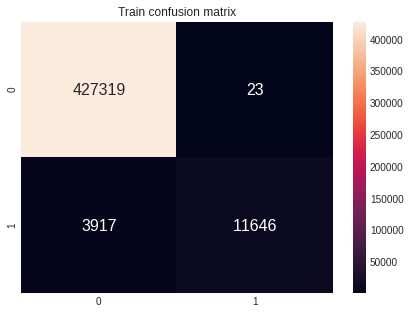

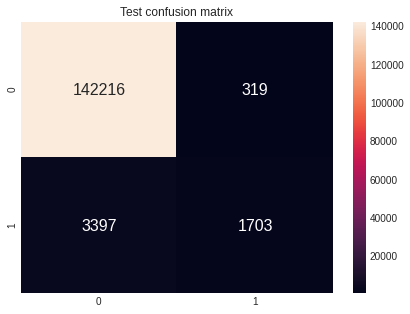

In [ ]:
train_cf = confusion_matrix(y_train.iloc[idx_train],y_train_pred)
plt.figure(figsize=(7,5))
sns.heatmap(train_cf,annot=True,annot_kws={"size": 16},fmt="0")
plt.title('Train confusion matrix')
plt.show()


cv_cf = confusion_matrix(y_train.iloc[idx_validation],y_test_pred)
plt.figure(figsize=(7,5))
sns.heatmap(cv_cf,annot=True,annot_kws={"size": 16},fmt="0")
plt.title('Test confusion matrix')
plt.show()

In [ ]:
y_pred_test = model.predict_proba(x_test)[:,1]
submission = pd.read_csv('data/sample_submission.csv')
submission['isFraud'] = y_pred_test
submission.to_csv('submission.csv',index=False)
submission.head()

TransactionID   isFraud
0        3663549  0.002513
1        3663550  0.004116
2        3663551  0.003241
3        3663552  0.001828
4        3663553  0.004069

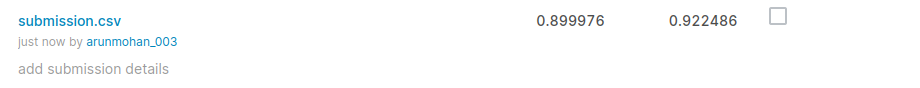

In [ ]:
# Local cv: 0.923162
# Public LB: 0.922486
# Private LB: 0.89976